In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## 탐색적 데이터 분석(EDA)

### 결측치 점검

In [2]:
df_raw = pd.read_csv('C:\\Users\\user\\Downloads\\0827_H2_data.csv')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 257 entries, id to hazard_psy3
dtypes: float64(178), int64(77), object(2)
memory usage: 29.3+ MB


In [3]:
# # 클래스 분포 확인
# print(df_raw['burnout60'].value_counts())
# print("번아웃클래스 이진으로 분류한다면: ", df_raw['burnout60'].value_counts().iloc[1:].sum(), "명")

In [4]:
# 결측치 개수가 높은 순위 중 타겟과 관련없는 변수 삭제

df = df_raw.drop(['emp_keep_a', 'hazard_phy_d','hazard_phy_a','hazard_phy_c','hazard_phy_e','hazard_phy_f','hazard_phy_g','hazard_phy_h', 'hazard_phy_i', 'ch_downsizing', 'job_c1_r', 'job_c1', 'emp_pay_type', 'skillmat', 'emp_comp_com_a','emp_comp_com_b','emp_comp_com_c','ch_ic','ch_restruct','wplace_sl','emp_noncon', 'wcomback'], axis = 1)

In [5]:
# 널값 개수와 비율 계산
null_summary = (
    df.isnull().sum()
      .to_frame("널값 개수")
      .assign(널값비율 = lambda x: (x["널값 개수"] / len(df_raw) * 100).round(2))
      .reset_index()
      .rename(columns={'index': '컬럼명'})
)

# 널값 있는 열만 필터링 & 비율 기준 내림차순 정렬
null_summary = (
    null_summary[null_summary["널값 개수"] > 0]
    .sort_values(by="널값비율", ascending=False)
    .reset_index(drop=True)
)

print(null_summary)

                  컬럼명  널값 개수  널값비율
0         comp_size_b    870  5.82
1        wtime_ftwork    584  3.90
2            emp_keep    581  3.88
3          emo_manual    307  2.05
4    wtime_resilience    279  1.87
..                ...    ...   ...
150       wsituation7      2  0.01
151      wsituation13      1  0.01
152            wstat1      1  0.01
153         winten2_a      2  0.01
154     wtime_length3      2  0.01

[155 rows x 3 columns]


In [6]:
# start 파일
# df.to_csv("2PD_v1_0822.csv", encoding="CP949")

### 중복 피쳐 삭제/8,9->결측치 수정

In [7]:
# 불필요한 피쳐 삭제하기 (14개)
df = df.drop(columns=["ptime_r", "stratification", "district", "household", "target", "mode", "hh_num", "eli_num", "hm_01_gender", "hm_01_year", "hm_01_estat", "hm_01_rel_t","wtime_week", "earning1_r"])

print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  panel_survey  ind  ind2  occ  \
0               6     40.0            1  ...             

In [8]:
# 전처리: 8, 9 NULL (5개)
cols = ["hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e"]

df[cols] = df[cols].replace([8, 9], pd.NA)

print(df['hazard_erg_a'].unique())
print(df['hazard_erg_b'].unique())
print(df['hazard_erg_c'].unique())
print(df['hazard_erg_d'].unique())
print(df['hazard_erg_e'].unique())

[6 2 1 7 5 4 3 <NA>]
[1 5 6 3 4 7 2 <NA>]
[ 7.  6.  2.  5.  4.  3.  1. nan]
[ 7.  2.  5.  4.  6.  3. nan  1.]
[ 7.  3.  5.  6.  4.  2.  1. nan]


In [9]:
# 잘못 변경된 변수명 복원
df.rename(columns={
    "wsituation": "wsituation8",
    "wsituation.1": "wsituation9",
    "disc": "disc9",
    "disc.1": "disc8"
}, inplace=True)

### 설문 문항 중 긍부정 변경

In [10]:
# 원래 이름 확인 필요
df['emp_tra_b'].value_counts()

emp_tra_b
2.0    9890
1.0    5053
Name: count, dtype: int64

In [11]:
df['heal_wsick1'].unique()
df['heal_wsick1'].value_counts()

heal_wsick1
2.0    11610
7.0     2630
1.0      675
Name: count, dtype: int64

In [12]:
cols = ["heal_wsick1"]

df[cols] = df[cols].replace(7,2)

print(df['heal_wsick1'].unique())
print(df['heal_wsick1'].value_counts())

[ 2.  1. nan]
heal_wsick1
2.0    14240
1.0      675
Name: count, dtype: int64


In [13]:
cols = [
   "heal_wsick1"
]

# 변환 딕셔너리 
reverse_map = {1: 2, 2: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])


print(df['heal_wsick1'].unique())
print(df['heal_wsick1'].value_counts())

[ 1.  2. nan]
heal_wsick1
1.0    14240
2.0      675
Name: count, dtype: int64


In [14]:
# 2점 척도 변환
cols = [
   "ch_me", 'heal_prob2', 'heal_prob3', 'heal_prob4'
]

# 변환 딕셔너리 
reverse_map = {1: 2, 2: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])


print(df['ch_me'].unique())
print(df['ch_me'].value_counts())

[ 1.  2. nan]
ch_me
1.0    12538
2.0     2273
Name: count, dtype: int64


In [15]:
df["wstat4"].head(10) 

0    2
1    2
2    2
3    3
4    5
5    5
6    5
7    5
8    5
9    5
Name: wstat4, dtype: int64

In [16]:
# 긍/부정 변경
# 5점 척도

cols = [
    "wstat4", "wstat6",
    "wwa1", "wwa2", "wwa3", "wwa4", "wwa5",
    "sleep1", "sleep2", "sleep3",
    "wsituation12", "wsituation14"
]

# 변환 딕셔너리 (5점 척도 역코딩)
reverse_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])

df["wstat4"].head(10) 

0    4
1    4
2    4
3    3
4    1
5    1
6    1
7    1
8    1
9    1
Name: wstat4, dtype: int64

In [17]:
# 3점 척도 
cols_2 = [
   "heal_lim1"
]

# 변환 딕셔너리 (3점 척도 역코딩)
reverse_map = {1: 3, 2: 2, 3: 1}

# 여러 열에 적용
for col in cols_2:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_2].head())
#%%
df["heal_lim1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: heal_lim1, dtype: float64

In [18]:
# 4점 척도
cols_1 = [
    "imte1", "imte2", "imte3", "imte4", "imte5",
]

# 변환 딕셔너리 (4점 척도 역코딩)
reverse_map = {1: 4, 2: 3, 3: 2, 4: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["imte1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    3.0
1    3.0
2    3.0
3    1.0
4    2.0
5    2.0
6    2.0
7    3.0
8    2.0
9    2.0
Name: imte1, dtype: float64

In [19]:
# 7점 척도
cols_1 = [
    "hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e", 'hazard_psy1', 'hazard_psy2', 'hazard_psy3'
]

# 변환 딕셔너리 (7점 척도 역코딩)
reverse_map = {1: 7, 2: 6, 3: 5, 5: 3, 6: 2, 7: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["hazard_erg_a"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    2.0
1    6.0
2    7.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: hazard_erg_a, dtype: object

### 연속형 변수 재범주화

In [20]:
df['heal_abs1'].value_counts()

heal_abs1
0.0      14127
2.0        181
1.0        127
3.0        113
5.0         80
7.0         65
10.0        31
8.0         25
4.0         24
6.0         10
15.0         9
20.0         6
30.0         6
14.0         5
13.0         5
12.0         4
90.0         3
60.0         2
11.0         1
180.0        1
120.0        1
50.0         1
21.0         1
Name: count, dtype: int64

In [21]:
# 범주화 

df["heal_abs1_group"] = np.where(df["heal_abs1"] == 0, 0, 1)
df['heal_abs1_group'] = df['heal_abs1_group'].map({0: 1, 1: 2})
#%%
print(df["heal_abs1_group"].head())
#%%
df["heal_abs1_group"].value_counts()


0    1
1    1
2    1
3    1
4    1
Name: heal_abs1_group, dtype: int64


heal_abs1_group
1    14127
2      829
Name: count, dtype: int64

In [22]:
# 구간 (0~60, 61~120, 121 이상)
bins = [0, 60, 120, float("inf")]
labels = [1, 2, 3]

df["ctime_group"] = pd.cut(df["ctime"], bins=bins, labels=labels, right=True)
#%%
print(df["ctime_group"].head())
#%%
df["ctime_group"].value_counts()
#%%

0      1
1      1
2      1
3      2
4    NaN
Name: ctime_group, dtype: category
Categories (3, int64): [1 < 2 < 3]


ctime_group
1    12582
2     1150
3      328
Name: count, dtype: int64

In [23]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['heal_abs1','ctime'], axis = 1)
print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  ind2  occ  occ2  comp_sizea_r  \
0               6     40.0            1  ...    46    3 

### 중복 피쳐 삭제

In [24]:
# 1차 프로젝트에서 파생변수 만들었던 변수 삭제
df = df.drop(['occ', 'occ2', 'age', 'earning2_r', 'wday_week', 'woutside4', 'wtime_r', 'wduration_y'], axis = 1)

## Feature Selection

### 상관관계 매트릭스 분석

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
# sns.heatmap(corr, cmap="coolwarm", center=0)
# plt.show()

In [26]:
# 상관계수 절댓값이 0.8 이상인 쌍만 추출 (자기 자신 제외)
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
        .stack()                                               
        .reset_index()
        .rename(columns={'level_0': '변수1', 'level_1': '변수2', 0: '상관계수'})
)

# 조건 필터링
high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]

print(high_corr.sort_values(by='상관계수', ascending=False).head(20))

                    변수1           변수2      상관계수
10231       comp_size_b  comp_sizeb_r  1.000000
10230       comp_size_b  comp_sizea_r  1.000000
15861             disc3         disc4  0.988628
21086               ind          ind2  0.985571
15758             disc2         disc3  0.984493
15759             disc2         disc4  0.982562
1804     compsize_group  comp_sizeb_r  0.975227
1660     compsize_group   comp_size_b  0.969841
15654             disc8         disc2  0.962101
15656             disc8         disc4  0.956305
15655             disc8         disc3  0.954483
15549             disc7         disc8  0.944109
15550             disc7         disc2  0.920967
21099      comp_sizea_r  comp_sizeb_r  0.920086
2195   compsize_group_a  comp_sizeb_r  0.916659
15552             disc7         disc4  0.913893
15551             disc7         disc3  0.913422
1803     compsize_group  comp_sizea_r  0.910546
2051   compsize_group_a   comp_size_b  0.893071
15443             disc6         disc7  0

In [27]:
unique_vars = set(high_corr['변수1']).union(set(high_corr['변수2']))
print("조건 충족하는 변수 개수:", len(unique_vars))
print("변수 목록:", unique_vars)

조건 충족하는 변수 개수: 23
변수 목록: {'winten3_d', 'ind2', 'disc4', 'woutside_group', 'disc3', 'compsize_group_a', 'winten3_c', 'comp_sizea_r', 'comp_sizeb_r', 'decla_a', 'winten2_b', 'comp_size_b', 'winten2_a', 'disc8', 'disc6', 'earning2_group_b', 'disc2', 'ind', 'decla_b', 'earning1', 'disc7', 'compsize_group', 'woutside4_a'}


In [28]:
# 상관분석 결과 필요없는 변수 삭제
df = df.drop(['comp_size_b', 'comp_sizea_r', 'comp_sizeb_r', 'ind', 'ind2', 'earning1', 'woutside4_a'], axis = 1)

In [29]:
# disc 변수 : 차별 유/무로 파생변수 생성
cols = ['disc1','disc2','disc3','disc4','disc5',
        'disc6','disc7','disc8','disc9','disc10','disc11']

# 하나라도 1이 있으면 1, 아니면 0
df['disc_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['disc_group'] = df['disc_group'].map({0: 1, 1: 2})

print(df['disc_group'].unique())

[2 1]


In [30]:
# decla 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['decla_a','decla_b']

# 하나라도 1이 있으면 1, 아니면 0
df['decla_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['decla_group'] = df['decla_group'].map({0: 1, 1: 2})

print(df['decla_group'].unique())

[2 1]


In [31]:
# winten2 변수 : 작업 강도가 세다로 파생변수 생성(7점 척도)
cols = ['winten2_a','winten2_b']

# 둘 중 하나라도 있으면 최대값
df['winten2_group'] = df[cols].max(axis=1, skipna=True)

print(df['winten2_group'].unique())

[ 5.  6.  7.  1.  4.  3.  2. nan]


In [32]:
# winten3 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e']

# 하나라도 1이 있으면 1, 아니면 0
df['winten3_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['winten3_group'] = df['winten3_group'].map({0: 1, 1: 2})

print(df['winten3_group'].unique())

[2 1]


In [33]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['disc1','disc2','disc3','disc4','disc5',
              'disc6','disc7','disc8','disc9','disc10','disc11','decla_a','decla_b','winten2_a','winten2_b', 'winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e'], axis = 1)

### 조작적 정의에 사용된 변수 삭제

In [34]:
df = df.drop(['weng1','weng2','weng3','wsituation14','wwa2','sleep2','sleep3','weng4','weng5','wsituation1','wstat4','wsituation2','wsituation12', 'wsituation10','wsituation9', 'emp_manaqual_a'], axis = 1)

### 모델의 피처 중요도 기반 삭제 

In [35]:
df = df.drop(['sleep1', 'emp_tra_b', 'ch_me', 'emp_winflu_a', 'emp_winflu_b'], axis = 1)

# 'heal_prob1', 'heal_prob2', 'heal_prob3', 'heal_prob4', 'heal_prob5', 'heal_prob6', 'heal_prob8'

### 인구 통계 변수 빼고 저장

In [36]:
df_new = df.drop(['id', 'area', 'gender', 'age_group', 'emp_period_group', 'wtime_group', 'marital', 'children', 'panel_survey', 'edu', 'occ_group_a', 'occ_t2_group_a'], axis = 1)

### 널값 삭제

In [37]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 157 entries, burnout60 to winten3_group
dtypes: category(1), float64(129), int64(24), object(3)
memory usage: 17.8+ MB


In [38]:
df_new = df_new.dropna()

In [39]:
df_new

,burnout60,wtime_length5,compsize_group,woutside_group,compsize_group_a,wday_week_group_a,woutside4_group_a,earning2_group_b,emp_stat,emp_con_term,...,income_bal,hazard_psy1,hazard_psy2,hazard_psy3,heal_abs1_group,ctime_group,disc_group,decla_group,winten2_group,winten3_group
0,lv1,2,4,0,1,2,2,5,1,2.0,...,4.0,3.0,4.0,3.0,1,1,2,2,5.0,2
1,lv2,2,11,0,3,2,2,4,1,2.0,...,3.0,4.0,4.0,4.0,1,1,2,2,6.0,2
2,lv1,2,1,0,1,3,2,4,1,2.0,...,3.0,6.0,6.0,6.0,1,1,2,2,5.0,2
3,lv1,2,10,0,3,2,1,4,1,2.0,...,1.0,1.0,1.0,1.0,1,2,2,2,7.0,2
5,lv1,2,10,0,3,2,3,4,1,1.0,...,1.0,1.0,1.0,1.0,1,1,2,2,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14949,lv1,1,12,1,3,2,3,5,1,2.0,...,3.0,1.0,1.0,2.0,1,1,2,2,4.0,2
14952,lv2,2,4,0,1,2,3,3,1,2.0,...,4.0,4.0,3.0,4.0,1,1,2,2,4.0,2
14953,lv1,2,4,0,1,2,3,4,1,2.0,...,3.0,4.0,3.0,3.0,1,1,2,2,5.0,2
14954,lv1,2,4,0,1,2,3,5,1,2.0,...,3.0,5.0,3.0,5.0,1,1,2,2,5.0,2


### 변수 타입 변경

In [40]:
print(df_new.select_dtypes(include=['object']).columns.tolist())
print(df_new.select_dtypes(include=['category']).columns.tolist())

['burnout60', 'hazard_erg_a', 'hazard_erg_b']
['ctime_group']


In [41]:
print(df_new.select_dtypes(include=['float64']).columns.tolist())

['emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_c', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_female', 'comp_sjob', 'ch_tech', 'ch_ps', 'imte1', 'imte2', 'imte3', 'imte4', 'imte5', 'safeinform', 'wsituation3', 'wsituation4', 'wsituation5', 'wsituation11', 'wsituation6', 'wsituation7', 'wsituation13', 'wstat1', 'wstat2', 'wstat5', 'wstat6', 'wstat7', 'emo_manual', 'asb5', 'asb6', 'asb7', 'wtime_con1', 'wtime_night_a', 'wtime_sun_a', 'wtime_sat_a', 'wtime_long_a', 'wtime_resilience', 'wtime_arr_a', 'wtime_ftwork', 'wtime_private', 'hazard_phy_b', 

In [42]:
num_cols = df.select_dtypes(include=['float64']).columns

for col in num_cols:
    min_val, max_val = df[col].min(), df[col].max()
    print(f"{col}: 범위=({min_val}, {max_val})")

emp_con_term: 범위=(1.0, 2.0)
emp_keep: 범위=(1.0, 2.0)
emp_own_mgmt: 범위=(1.0, 2.0)
emp_fptime: 범위=(1.0, 2.0)
emp_wage: 범위=(1.0, 3.0)
emp_stat_sp: 범위=(1.0, 2.0)
income_pos_a: 범위=(1.0, 2.0)
income_pos_b: 범위=(1.0, 2.0)
income_pos_c: 범위=(1.0, 2.0)
income_pos_d: 범위=(1.0, 2.0)
income_pos_e: 범위=(1.0, 2.0)
income_pos_f: 범위=(1.0, 2.0)
income_pos_g: 범위=(1.0, 2.0)
income_pos_h: 범위=(1.0, 2.0)
income_pos_i: 범위=(1.0, 2.0)
income_pos_j: 범위=(1.0, 2.0)
emp_place: 범위=(1.0, 2.0)
emp_suggest_a: 범위=(1.0, 2.0)
emp_suggest_b: 범위=(1.0, 2.0)
emp_manaqual_b: 범위=(1.0, 5.0)
emp_manaqual_c: 범위=(1.0, 5.0)
emp_manaqual_d: 범위=(1.0, 5.0)
emp_manaqual_e: 범위=(1.0, 5.0)
emp_comp_ass_a: 범위=(1.0, 5.0)
emp_comp_ass_b: 범위=(1.0, 5.0)
emp_comp_ass_c: 범위=(1.0, 5.0)
emp_comp_ass_d: 범위=(1.0, 5.0)
emp_comp_ass_e: 범위=(1.0, 5.0)
emp_comp_ass_f: 범위=(1.0, 5.0)
emp_rep: 범위=(1.0, 3.0)
emp_winflu_c: 범위=(1.0, 7.0)
emp_tra_c: 범위=(1.0, 2.0)
emp_tra_d: 범위=(1.0, 2.0)
wsector: 범위=(1.0, 4.0)
comp_female: 범위=(1.0, 3.0)
comp_sjob: 범위=(1.0, 4.0)
ch_t

In [43]:
# 데이터 타입 변경
df_new['hazard_erg_a'] = df_new['hazard_erg_a'].astype('int64')
df_new['hazard_erg_b'] = df_new['hazard_erg_b'].astype('int64')
df_new['ctime_group'] = df_new['ctime_group'].astype('int64')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11344 entries, 0 to 14955
Columns: 157 entries, burnout60 to winten3_group
dtypes: float64(129), int64(27), object(1)
memory usage: 13.7+ MB


In [44]:
# 타겟 클래스번호 전처리
df_new['burnout60'] = df_new['burnout60'].replace("lv1", 1)
df_new['burnout60'] = df_new['burnout60'].replace("lv2", 2)
df_new['burnout60'] = df_new['burnout60'].replace("lv3", 3)
df_new['burnout60'].unique()

array([1, 2, 3], dtype=int64)

In [45]:
df_new['burnout60'] = df_new['burnout60'].astype('int64')

In [46]:
df_new['burnout60'] = df_new['burnout60'] - 1

In [47]:
df_new['burnout60'].unique()

array([0, 1, 2], dtype=int64)

In [48]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11344 entries, 0 to 14955
Columns: 157 entries, burnout60 to winten3_group
dtypes: float64(129), int64(28)
memory usage: 13.7 MB


## 모델 적용

### FULL model(multiclass)(LGBM)

In [49]:
# 클래스 분포 확인
print(df_new['burnout60'].value_counts())
print("번아웃클래스 이진으로 분류한다면: ", df_new['burnout60'].value_counts().iloc[1:].sum(), "명")

burnout60
0    9704
1    1424
2     216
Name: count, dtype: int64
번아웃클래스 이진으로 분류한다면:  1640 명


In [51]:
# 학습(훈련) 데이터
train_X = df_new.drop(['burnout60'], axis = 1)
train_Y = df_new["burnout60"]

print("train_X 데이터: ", train_X.shape)
print("train_Y 데이터: ", train_Y.shape)

train_X 데이터:  (11344, 156)
train_Y 데이터:  (11344,)


In [52]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split

# 1차 분할: Train (80%) vs Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=42, stratify=train_Y
)

# 2차 분할: Train 내부에서 다시 Train (80%) vs Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (7260, 156) (7260,)
Validation shape: (1815, 156) (1815,)
Test shape: (2269, 156) (2269,)


In [53]:
print("Train 클래스 분포:")
print(y_train.value_counts())               
print(y_train.value_counts(normalize=True))  

Train 클래스 분포:
burnout60
0    6210
1     911
2     139
Name: count, dtype: int64
burnout60
0    0.855372
1    0.125482
2    0.019146
Name: proportion, dtype: float64


In [54]:
print("Test 클래스 분포:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Test 클래스 분포:
burnout60
0    1941
1     285
2      43
Name: count, dtype: int64
burnout60
0    0.855443
1    0.125606
2    0.018951
Name: proportion, dtype: float64


#### 모델 적용(multiclass)(LGBM)

In [55]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# 모델 정의
model_tune = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    boost_from_average= False,
    class_weight="balanced",
    random_state=42,
    n_estimators=1000
)

# 학습
model_tune.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

best_iter = model_tune.best_iteration_
print("Best iteration (from tuning):", best_iter)

c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7260, number of used features: 148
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.411501
[100]	valid_0's multi_logloss: 0.362524
[150]	valid_0's multi_logloss: 0.36193
Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.358407
Best iteration (from tuning): 125


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model_tune.predict(X_val)

print("Validation 예측 분포:")
print(pd.Series(y_val_pred).value_counts().sort_index())

# 혼동행렬
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_val_pred))

# 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_val, y_val_pred))

Validation 예측 분포:
0    1533
1     259
2      23
Name: count, dtype: int64

혼동 행렬:
[[1426  126    1]
 [ 100  117   11]
 [   7   16   11]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1553
           1       0.45      0.51      0.48       228
           2       0.48      0.32      0.39        34

    accuracy                           0.86      1815
   macro avg       0.62      0.58      0.60      1815
weighted avg       0.86      0.86      0.86      1815



#### SMOTE 적용

In [57]:
# 기존 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

continuous_cols = train_X.select_dtypes(include=['float64', 'int64']).columns

# MinMaxScaler 적용
scaler = MinMaxScaler()
X_train_scaled = train_X.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(train_X[continuous_cols])

In [58]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split

# 1차 분할: Train (80%) vs Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=42, stratify=train_Y
)

# 2차 분할: Train 내부에서 다시 Train (80%) vs Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (7260, 156) (7260,)
Validation shape: (1815, 156) (1815,)
Test shape: (2269, 156) (2269,)


In [59]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# SMOTE-ENN 적용 (Train만)
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)
print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
2    6210
1    6178
0    2723
Name: count, dtype: int64


In [60]:
# 모델 학습 (Train_res로 학습, Validation으로 평가)
model_tune.fit(X_train_res, y_train_res)

# Validation 성능 확인
y_val_pred = model_tune.predict(X_val)
print("Validation Report:\n", classification_report(y_val, y_val_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30685
[LightGBM] [Info] Number of data points in the train set: 15111, number of used features: 149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [61]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model_tune.predict(X_val)

print("Validation 예측 분포:")
print(pd.Series(y_val_pred).value_counts().sort_index())

# 혼동행렬
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_val_pred))

# 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_val, y_val_pred))

Validation 예측 분포:
0    1351
1     448
2      16
Name: count, dtype: int64

혼동 행렬:
[[1286  266    1]
 [  62  160    6]
 [   3   22    9]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1553
           1       0.36      0.70      0.47       228
           2       0.56      0.26      0.36        34

    accuracy                           0.80      1815
   macro avg       0.62      0.60      0.57      1815
weighted avg       0.87      0.80      0.82      1815



#### 최종 모델

In [61]:
# 최종 학습 
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

In [62]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# SMOTE-ENN 적용 (Train만)
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_final, y_final)
print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
2    7763
1    7714
0    3515
Name: count, dtype: int64


In [63]:
# 최종 모델

final_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    boost_from_average= False,
    class_weight="balanced",
    random_state=42,
    n_estimators=best_iter  # 최적 반복 수 적용
)

final_model.fit(X_train_res, y_train_res)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35598
[LightGBM] [Info] Number of data points in the train set: 18992, number of used features: 150


LGBMClassifier(boost_from_average=False, class_weight='balanced',
               n_estimators=130, num_class=3, objective='multiclass',
               random_state=42)

In [64]:
# 최종 평가
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = final_model.predict(X_test)

print("분류 리포트 (Test):")
print(classification_report(y_test, y_test_pred))

print("혼동 행렬 (Test):")
print(confusion_matrix(y_test, y_test_pred))

분류 리포트 (Test):
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1941
           1       0.38      0.67      0.49       285
           2       0.68      0.30      0.42        43

    accuracy                           0.82      2269
   macro avg       0.67      0.61      0.60      2269
weighted avg       0.87      0.82      0.84      2269

혼동 행렬 (Test):
[[1657  284    0]
 [  87  192    6]
 [   3   27   13]]


#### feature importance 시각화

In [62]:
# feature importance (gain 기준)
importance = pd.DataFrame(model_tune.booster_.feature_importance(importance_type='gain'), index=X_train.columns, columns=["importance"]).sort_values(by="importance",ascending = True).tail(20)
importance

# 변수중요도 비율로 전환
importance['importance_pct'] = importance['importance'] / importance['importance'].sum() * 100
importance.head(20)

,importance,importance_pct
hazard_phy_b,1418.024962,1.116404
wstat7,1657.563376,1.304992
emp_manaqual_b,1785.283052,1.405545
who5,1808.594654,1.423898
wsituation6,1911.090312,1.504592
wwa3,2084.587664,1.641186
emp_manaqual_c,2103.408567,1.656004
wstat5,2179.807179,1.716152
wsituation7,3001.681708,2.363210
wwa1,3208.693129,2.526189


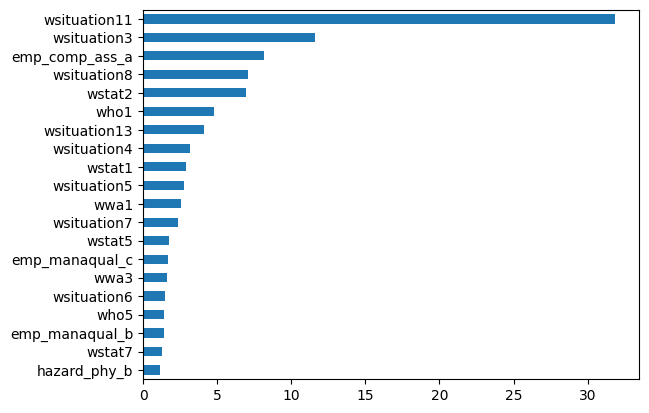

In [63]:
importance['importance_pct'].plot.barh()
plt.show()

#### Shap 클래스2(번아웃 진단군) 변수 중요도 확인

In [64]:
# LightGBM 모델 학습된 객체: model_tune
explainer = shap.TreeExplainer(model_tune)

In [66]:
# SHAP 값 (Explanation 객체)
shap_values = explainer(X_train_res)
shap_values_class2 = shap_values[:,:,2]

# SHAP 절댓값 평균으로 변수 중요도 계산
shap_importance = np.abs(shap_values_class2.values).mean(axis=0)

fi_shap = pd.DataFrame({
    'feature': X_train.columns,
    'importance_shap': shap_importance
}).sort_values(by='importance_shap', ascending=False).reset_index(drop=True)

print(fi_shap.head(20))

         feature  importance_shap
0    wsituation8         1.795231
1   wsituation11         1.793270
2           who1         0.880372
3         wstat2         0.762587
4         wstat1         0.709940
5    wsituation3         0.673126
6    wsituation6         0.656233
7           who5         0.603411
8     income_con         0.592727
9           wwa1         0.564450
10          wwa3         0.546623
11        wstat5         0.509085
12  hazard_phy_b         0.508856
13     wpalce_ch         0.489891
14       condim5         0.476583
15  income_pos_h         0.472083
16       condim1         0.441897
17  hazard_erg_d         0.419574
18   wsituation4         0.418361
19    safeinform         0.405881


In [67]:
# 변수 이름 저장
top_features = fi_shap['feature'].head(20).tolist()

X_top = X_train[top_features]
X_top

,wsituation8,wsituation11,who1,wstat2,wstat1,wsituation3,wsituation6,who5,income_con,wwa1,wwa3,wstat5,hazard_phy_b,wpalce_ch,condim5,income_pos_h,condim1,hazard_erg_d,wsituation4,safeinform
9765,2,2.0,3.0,2.0,1.0,1.0,2.0,3.0,1.0,4.0,4.0,2.0,7.0,4.0,2.0,2.0,1.0,1.0,2.0,2.0
4450,2,3.0,5.0,1.0,2.0,3.0,3.0,5.0,3.0,3.0,3.0,3.0,5.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0
14306,2,2.0,3.0,2.0,2.0,1.0,2.0,3.0,1.0,1.0,3.0,2.0,6.0,4.0,2.0,2.0,2.0,4.0,2.0,2.0
5979,3,4.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,5.0,3.0,4.0,2.0,1.0,1.0,2.0,3.0,2.0,1.0
622,2,3.0,2.0,2.0,2.0,2.0,3.0,2.0,1.0,2.0,2.0,2.0,7.0,4.0,2.0,2.0,1.0,5.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,3,3.0,1.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,2.0,4.0,6.0,4.0,2.0,1.0,1.0,2.0,2.0,2.0
4703,3,3.0,2.0,3.0,2.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,5.0,4.0,2.0,1.0,2.0,1.0,3.0,2.0
11564,3,2.0,2.0,2.0,3.0,3.0,4.0,3.0,2.0,2.0,2.0,3.0,7.0,4.0,1.0,1.0,1.0,1.0,3.0,2.0
11174,3,3.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,4.0,3.0,2.0,4.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0


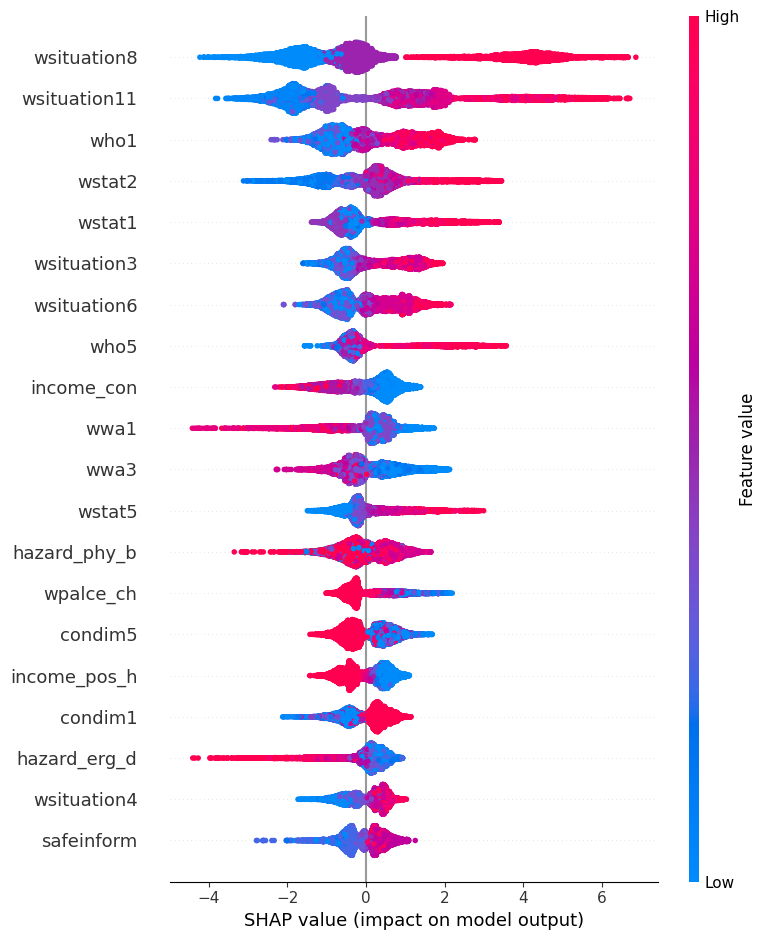

In [68]:
# summary plot
shap.summary_plot(
    shap_values_class2,
    X_train_res,
    feature_names=X_train.columns  
)

### 2차 모델 - 변수 선택 20개(클래스2 중요도 기반)

In [69]:
# 학습(훈련) 데이터
train_X = df_new.drop(['burnout60'], axis = 1)
train_Y = df_new["burnout60"]

print("train_X 데이터: ", train_X.shape)
print("train_Y 데이터: ", train_Y.shape)

train_X 데이터:  (11344, 156)
train_Y 데이터:  (11344,)


In [70]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

train_X = train_X[top_features]

print("Train shape:", train_X.shape, train_Y.shape)

Train shape: (11344, 20) (11344,)


In [71]:
# 기존 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

continuous_cols = train_X.select_dtypes(include=['float64', 'int64']).columns

# MinMaxScaler 적용
scaler = MinMaxScaler()
X_train_scaled = train_X.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(train_X[continuous_cols])

In [72]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split

# 1차 분할: Train (80%) vs Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=42, stratify=train_Y
)

# 2차 분할: Train 내부에서 다시 Train (80%) vs Validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (7260, 20) (7260,)
Validation shape: (1815, 20) (1815,)
Test shape: (2269, 20) (2269,)


In [73]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# SMOTE-ENN 적용 (Train만)
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)
print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
2    6208
1    6144
0    3740
Name: count, dtype: int64


In [74]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# 모델 정의
model_tune = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    boost_from_average= False,
    class_weight="balanced",
    random_state=42,
    n_estimators=1000
)

# 학습
model_tune.fit(
    X_train_res, y_train_res,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

best_iter = model_tune.best_iteration_
print("Best iteration (from tuning):", best_iter)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4846
[LightGBM] [Info] Number of data points in the train set: 16092, number of used features: 20
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.448419
[100]	valid_0's multi_logloss: 0.45646
Early stopping, best iteration is:
[58]	valid_0's multi_logloss: 0.444605
Best iteration (from tuning): 58


In [75]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model_tune.predict(X_val)

print("Validation 예측 분포:")
print(pd.Series(y_val_pred).value_counts().sort_index())

# 혼동행렬
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_val_pred))

# 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_val, y_val_pred))

Validation 예측 분포:
0    1439
1     343
2      33
Name: count, dtype: int64

혼동 행렬:
[[1351  195    7]
 [  84  128   16]
 [   4   20   10]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1553
           1       0.37      0.56      0.45       228
           2       0.30      0.29      0.30        34

    accuracy                           0.82      1815
   macro avg       0.54      0.58      0.55      1815
weighted avg       0.86      0.82      0.83      1815



In [79]:
# 최종 학습 
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

print("Train shape:", X_final.shape, y_final.shape)

Train shape: (9075, 20) (9075,)


In [80]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# SMOTE-ENN 적용 (Train만)
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_final, y_final)
print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
2    7611
1    7610
0    5100
Name: count, dtype: int64


In [81]:
# 최종 모델

final_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    boost_from_average= False,
    class_weight="balanced",
    random_state=42,
    n_estimators=best_iter  # 최적 반복 수 적용
)

final_model.fit(X_final, y_final)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 94
[LightGBM] [Info] Number of data points in the train set: 9075, number of used features: 20


LGBMClassifier(boost_from_average=False, class_weight='balanced',
               n_estimators=60, num_class=3, objective='multiclass',
               random_state=42)

In [82]:
# 최종 평가
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = final_model.predict(X_test)

print("분류 리포트 (Test):")
print(classification_report(y_test, y_test_pred))

print("혼동 행렬 (Test):")
print(confusion_matrix(y_test, y_test_pred))

분류 리포트 (Test):
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1941
           1       0.30      0.61      0.40       285
           2       0.38      0.58      0.46        43

    accuracy                           0.77      2269
   macro avg       0.54      0.66      0.58      2269
weighted avg       0.86      0.77      0.80      2269

혼동 행렬 (Test):
[[1539  390   12]
 [  82  175   28]
 [   2   16   25]]


### 3차 모델 - 이진 분류

In [49]:
# 클래스 분포 확인
print(df_new['burnout60'].value_counts())
print("번아웃클래스 이진으로 분류한다면: ", df_new['burnout60'].value_counts().iloc[1:].sum(), "명")

burnout60
0    9704
1    1424
2     216
Name: count, dtype: int64
번아웃클래스 이진으로 분류한다면:  1640 명


In [50]:
# 1, 2 클래스 결합
df_new['burnout60'] = df_new['burnout60'].replace(2, 1)

print(df_new['burnout60'].value_counts())
print("번아웃클래스 이진 분류: ", df_new['burnout60'].value_counts().iloc[1:].sum(), "명")

burnout60
0    9704
1    1640
Name: count, dtype: int64
번아웃클래스 이진 분류:  1640 명


In [51]:
# 학습(훈련) 데이터
train_X = df_new.drop(['burnout60'], axis = 1)
train_Y = df_new["burnout60"]

print("train_X 데이터: ", train_X.shape)
print("train_Y 데이터: ", train_Y.shape)

train_X 데이터:  (11344, 156)
train_Y 데이터:  (11344,)


In [52]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split

# 1차 분할: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    train_X, train_Y, test_size=0.4, random_state=42, stratify=train_Y
)

# 2차 분할: Validation (20%) vs Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (6806, 156) (6806,)
Validation shape: (2269, 156) (2269,)
Test shape: (2269, 156) (2269,)


In [53]:
print("Train 클래스 분포:")
print(y_train.value_counts())               
print(y_train.value_counts(normalize=True))  

Train 클래스 분포:
burnout60
0    5822
1     984
Name: count, dtype: int64
burnout60
0    0.855422
1    0.144578
Name: proportion, dtype: float64


In [54]:
print("Test 클래스 분포:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Test 클래스 분포:
burnout60
0    1941
1     328
Name: count, dtype: int64
burnout60
0    0.855443
1    0.144557
Name: proportion, dtype: float64


In [55]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# 모델 정의
model_tune = LGBMClassifier(
    objective="binary",
    boost_from_average= False,
    class_weight="balanced",
    random_state=42,
    n_estimators=1000
)

# 학습
model_tune.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

best_iter = model_tune.best_iteration_
print("Best iteration (from tuning):", best_iter)


c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\user\anaconda3\envs\python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Number of positive: 984, number of negative: 5822
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 6806, number of used features: 148
Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.371773
[100]	valid_0's binary_logloss: 0.326092
[150]	valid_0's binary_logloss: 0.313913
[200]	valid_0's binary_logloss: 0.310043
[250]	valid_0's binary_logloss: 0.312561
Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.308984
Best iteration (from tuning): 213


In [56]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model_tune.predict(X_val)

print("Validation 예측 분포:")
print(pd.Series(y_val_pred).value_counts().sort_index())

# 혼동행렬
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_val_pred))

# 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_val, y_val_pred))

Validation 예측 분포:
0    1953
1     316
Name: count, dtype: int64

혼동 행렬:
[[1802  139]
 [ 151  177]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1941
           1       0.56      0.54      0.55       328

    accuracy                           0.87      2269
   macro avg       0.74      0.73      0.74      2269
weighted avg       0.87      0.87      0.87      2269



#### SMOTE 적용

In [57]:
# 기존 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

continuous_cols = train_X.select_dtypes(include=['float64', 'int64']).columns


In [58]:
# MinMaxScaler 적용
scaler = MinMaxScaler()
X_train_scaled = train_X.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(train_X[continuous_cols])

In [60]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split

# 1차 분할: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_train_scaled, train_Y, test_size=0.4, random_state=42, stratify=train_Y
)

# 2차 분할: Validation (20%) vs Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (6806, 156) (6806,)
Validation shape: (2269, 156) (2269,)
Test shape: (2269, 156) (2269,)


In [61]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# SMOTE-ENN 적용 (Train만)
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)
print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
1    5769
0    2462
Name: count, dtype: int64


In [62]:
# 모델 학습 (Train_res로 학습, Validation으로 평가)
model_tune.fit(X_train_res, y_train_res)

# Validation 성능 확인
y_val_pred = model_tune.predict(X_val)
print("Validation Report:\n", classification_report(y_val, y_val_pred))

[LightGBM] [Info] Number of positive: 5769, number of negative: 2462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32307
[LightGBM] [Info] Number of data points in the train set: 8231, number of used features: 150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

In [63]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model_tune.predict(X_val)

print("Validation 예측 분포:")
print(pd.Series(y_val_pred).value_counts().sort_index())

# 혼동행렬
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_val_pred))

# 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_val, y_val_pred))

Validation 예측 분포:
0    1683
1     586
Name: count, dtype: int64

혼동 행렬:
[[1604  337]
 [  79  249]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1941
           1       0.42      0.76      0.54       328

    accuracy                           0.82      2269
   macro avg       0.69      0.79      0.72      2269
weighted avg       0.88      0.82      0.84      2269



In [ ]:
# 최종 학습 데이터 
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

In [65]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# SMOTE-ENN 적용 (Train만)
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_final, y_final)
print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
1    7688
0    3563
Name: count, dtype: int64


In [66]:
# 최종 모델 학습

final_model = LGBMClassifier(
    objective="binary",
    boost_from_average= False,
    class_weight="balanced",
    random_state=42,
    n_estimators=best_iter  # 최적 반복 수 적용
)

final_model.fit(X_train_res, y_train_res)


[LightGBM] [Info] Number of positive: 7688, number of negative: 3563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33451
[LightGBM] [Info] Number of data points in the train set: 11251, number of used features: 150


LGBMClassifier(boost_from_average=False, class_weight='balanced',
               n_estimators=213, objective='binary', random_state=42)

In [67]:
# 최종 평가
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = final_model.predict(X_test)

print("분류 리포트 (Test):")
print(classification_report(y_test, y_test_pred))

print("혼동 행렬 (Test):")
print(confusion_matrix(y_test, y_test_pred))

분류 리포트 (Test):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1941
           1       0.48      0.71      0.57       328

    accuracy                           0.85      2269
   macro avg       0.71      0.79      0.74      2269
weighted avg       0.88      0.85      0.86      2269

혼동 행렬 (Test):
[[1686  255]
 [  94  234]]


### 4차 모델 - 하이퍼파라미터 튜닝

In [ ]:
# !pip install optuna

   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 2.1/2.1 MB 39.6 MB/s  0:00:00

   --------------- ------------------------ 3/8 [greenlet]
   ------------------------- -------------- 5/8 [sqlalchemy]
   ------------------------- -------------- 5/8 [sqlalchemy]
   ------------------------- -------------- 5/8 [sqlalchemy]
   ------------------------- -------------- 5/8 [sqlalchemy]
   ------------------------- -------------- 5/8 [sqlalchemy]
   ------------------------------ --------- 6/8 [alembic]
   ----------------------------------- ---- 7/8 [optuna]
   ----------------------------------- ---- 7/8 [optuna]
   ---------------------------------------- 8/8 [optuna]



In [70]:
# 학습(훈련) 데이터
train_X = df_new.drop(['burnout60'], axis = 1)
train_Y = df_new["burnout60"]

print("train_X 데이터: ", train_X.shape)
print("train_Y 데이터: ", train_Y.shape)

train_X 데이터:  (11344, 156)
train_Y 데이터:  (11344,)


In [71]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

train_X = train_X[top_features]

print("Train shape:", train_X.shape, train_Y.shape)

Train shape: (11344, 20) (11344,)


In [ ]:
# # 기존 데이터 스케일링
# from sklearn.preprocessing import MinMaxScaler

# continuous_cols = train_X.select_dtypes(include=['float64', 'int64']).columns

# # MinMaxScaler 적용
# scaler = MinMaxScaler()
# X_train_scaled = train_X.copy()
# X_train_scaled[continuous_cols] = scaler.fit_transform(train_X[continuous_cols])

In [72]:
# 검증데이터 나누기
from sklearn.model_selection import train_test_split

# 1차 분할: Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    train_X, train_Y, test_size=0.4, random_state=42, stratify=train_Y
)

# 2차 분할: Validation (20%) vs Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (6806, 20) (6806,)
Validation shape: (2269, 20) (2269,)
Test shape: (2269, 20) (2269,)


In [73]:
print("Train 클래스 분포:")
print(y_train.value_counts())               
print(y_train.value_counts(normalize=True))  

Train 클래스 분포:
burnout60
0    5822
1     854
2     130
Name: count, dtype: int64
burnout60
0    0.855422
1    0.125478
2    0.019101
Name: proportion, dtype: float64


#### SMOTE 적용

In [ ]:
# from imblearn.combine import SMOTEENN
# from imblearn.over_sampling import SMOTE
# from lightgbm import LGBMClassifier
# from sklearn.metrics import classification_report
# import pandas as pd

# # SMOTE-ENN 적용 (Train만)
# smote = SMOTE(random_state=42, k_neighbors=3)
# smote_enn = SMOTEENN(random_state=42, smote=smote)

# X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)
# print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
2    5803
1    5704
0    3812
Name: count, dtype: int64


In [74]:
import optuna
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 3,
        "boosting_type": "gbdt",
        "metric": "multi_logloss",
        "verbosity": -1,
        "random_state": 42,
        "class_weight": "balanced",

        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
    }

    # 모델 학습
    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(50), log_evaluation(50)] 
    )

    y_pred = model.predict(X_val)
    f1_class2 = f1_score(y_val, y_pred, average=None, labels=[0,1,2])[2]
    return f1_class2

In [75]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  

[I 2025-09-01 18:20:03,288] A new study created in memory with name: no-name-47669459-9c02-4156-a266-e98f8ec47db1


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.585095
[100]	valid_0's multi_logloss: 0.551044
[150]	valid_0's multi_logloss: 0.53301
[200]	valid_0's multi_logloss: 0.522816
[250]	valid_0's multi_logloss: 0.515827
[300]	valid_0's multi_logloss: 0.511792
[350]	valid_0's multi_logloss: 0.512241
[400]	valid_0's multi_logloss: 0.511669
Early stopping, best iteration is:
[383]	valid_0's multi_logloss: 0.510762


[I 2025-09-01 18:20:03,764] Trial 0 finished with value: 0.41237113402061853 and parameters: {'learning_rate': 0.07741197540019404, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 50, 'subsample': 0.6276802723868806, 'colsample_bytree': 0.5560007564686029, 'reg_alpha': 1.6618771709861323e-05, 'reg_lambda': 0.13624860253633256, 'min_data_in_leaf': 77, 'feature_fraction': 0.9109771495093149}. Best is trial 0 with value: 0.41237113402061853.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.504016
[100]	valid_0's multi_logloss: 0.463301
[150]	valid_0's multi_logloss: 0.451749
[200]	valid_0's multi_logloss: 0.455959
Early stopping, best iteration is:
[155]	valid_0's multi_logloss: 0.450689


[I 2025-09-01 18:20:04,218] Trial 1 finished with value: 0.4634146341463415 and parameters: {'learning_rate': 0.08559754668683064, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 41, 'subsample': 0.5428519579439248, 'colsample_bytree': 0.7263901898652463, 'reg_alpha': 4.8884054961586127e-08, 'reg_lambda': 0.002614203387414452, 'min_data_in_leaf': 18, 'feature_fraction': 0.7181411590585919}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.625681
[100]	valid_0's multi_logloss: 0.58303
[150]	valid_0's multi_logloss: 0.568854
[200]	valid_0's multi_logloss: 0.562937
[250]	valid_0's multi_logloss: 0.560682


[I 2025-09-01 18:20:04,506] Trial 2 finished with value: 0.4153846153846154 and parameters: {'learning_rate': 0.06258568568382611, 'num_leaves': 26, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.7673498438918653, 'colsample_bytree': 0.8311994274542458, 'reg_alpha': 8.16670063380763, 'reg_lambda': 0.004014590517121958, 'min_data_in_leaf': 73, 'feature_fraction': 0.7483004537363562}. Best is trial 1 with value: 0.4634146341463415.


[300]	valid_0's multi_logloss: 0.559357
Early stopping, best iteration is:
[284]	valid_0's multi_logloss: 0.559286
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.505269
[100]	valid_0's multi_logloss: 0.486621


[I 2025-09-01 18:20:04,746] Trial 3 finished with value: 0.4175824175824176 and parameters: {'learning_rate': 0.176521263394489, 'num_leaves': 85, 'max_depth': 7, 'min_child_samples': 88, 'subsample': 0.981558598464483, 'colsample_bytree': 0.8390548195382481, 'reg_alpha': 6.999845135772362e-05, 'reg_lambda': 0.14758482301396125, 'min_data_in_leaf': 33, 'feature_fraction': 0.7741070976736296}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.492531
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.484495
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.566272
[100]	valid_0's multi_logloss: 0.526438
[150]	valid_0's multi_logloss: 0.50872
[200]	valid_0's multi_logloss: 0.501799
[250]	valid_0's multi_logloss: 0.500544
[300]	valid_0's multi_logloss: 0.501872
Early stopping, best iteration is:
[273]	valid_0's multi_logloss: 0.500071


[I 2025-09-01 18:20:05,178] Trial 4 finished with value: 0.4 and parameters: {'learning_rate': 0.09704890976194691, 'num_leaves': 36, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.9938147849654599, 'colsample_bytree': 0.9439543553641712, 'reg_alpha': 3.063718492865498e-07, 'reg_lambda': 0.003270251717654569, 'min_data_in_leaf': 97, 'feature_fraction': 0.9391917650115423}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.523166
[100]	valid_0's multi_logloss: 0.49287
[150]	valid_0's multi_logloss: 0.48896
Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 0.488623


[I 2025-09-01 18:20:05,408] Trial 5 finished with value: 0.4077669902912621 and parameters: {'learning_rate': 0.15896990134497543, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 95, 'subsample': 0.5269787343719936, 'colsample_bytree': 0.6305975852018729, 'reg_alpha': 1.5065665108557478, 'reg_lambda': 5.035523098136441e-07, 'min_data_in_leaf': 30, 'feature_fraction': 0.7314062135044572}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.636892
[100]	valid_0's multi_logloss: 0.600759
[150]	valid_0's multi_logloss: 0.588086
[200]	valid_0's multi_logloss: 0.578452
[250]	valid_0's multi_logloss: 0.569946
[300]	valid_0's multi_logloss: 0.563069
[350]	valid_0's multi_logloss: 0.55944
[400]	valid_0's multi_logloss: 0.557683
[450]	valid_0's multi_logloss: 0.555863
[500]	valid_0's multi_logloss: 0.555879


[I 2025-09-01 18:20:05,756] Trial 6 finished with value: 0.35772357723577236 and parameters: {'learning_rate': 0.10201261262608556, 'num_leaves': 150, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.5036138287146512, 'colsample_bytree': 0.8001706150810327, 'reg_alpha': 3.26594296584853e-07, 'reg_lambda': 0.19555377553191933, 'min_data_in_leaf': 69, 'feature_fraction': 0.6523151350905986}. Best is trial 1 with value: 0.4634146341463415.


[550]	valid_0's multi_logloss: 0.555091
Early stopping, best iteration is:
[536]	valid_0's multi_logloss: 0.55475
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.814952
[100]	valid_0's multi_logloss: 0.719442
[150]	valid_0's multi_logloss: 0.676106
[200]	valid_0's multi_logloss: 0.652838
[250]	valid_0's multi_logloss: 0.63934
[300]	valid_0's multi_logloss: 0.629897
[350]	valid_0's multi_logloss: 0.621694
[400]	valid_0's multi_logloss: 0.615136
[450]	valid_0's multi_logloss: 0.610268
[500]	valid_0's multi_logloss: 0.605973
[550]	valid_0's multi_logloss: 0.602716
[600]	valid_0's multi_logloss: 0.599068
[650]	valid_0's multi_logloss: 0.596432
[700]	valid_0's multi_logloss: 0.594228
[750]	valid_0's multi_logloss: 0.592501
[800]	valid_0's multi_logloss: 0.590743
[850]	valid_0's multi_logloss: 0.589373
[900]	valid_0's multi_logloss: 0.58826
[950]	valid_0's multi_logloss: 0.586829
[1000]	valid_0's multi_logloss: 0.585887
Did not meet early stopping

[I 2025-09-01 18:20:06,342] Trial 7 finished with value: 0.34210526315789475 and parameters: {'learning_rate': 0.020358456907183027, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 81, 'subsample': 0.5862513155395443, 'colsample_bytree': 0.8546268536760941, 'reg_alpha': 0.2758819643844238, 'reg_lambda': 7.777864791974737, 'min_data_in_leaf': 89, 'feature_fraction': 0.7546925627363027}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.642648
[100]	valid_0's multi_logloss: 0.603093
[150]	valid_0's multi_logloss: 0.589308
[200]	valid_0's multi_logloss: 0.57835
[250]	valid_0's multi_logloss: 0.569393
[300]	valid_0's multi_logloss: 0.564496
[350]	valid_0's multi_logloss: 0.55961
[400]	valid_0's multi_logloss: 0.556178
[450]	valid_0's multi_logloss: 0.55309
[500]	valid_0's multi_logloss: 0.551763
[550]	valid_0's multi_logloss: 0.54972


[I 2025-09-01 18:20:06,761] Trial 8 finished with value: 0.39669421487603307 and parameters: {'learning_rate': 0.08223190497824678, 'num_leaves': 126, 'max_depth': 3, 'min_child_samples': 57, 'subsample': 0.9556569598154127, 'colsample_bytree': 0.6858769475198652, 'reg_alpha': 1.1735857452285237e-08, 'reg_lambda': 5.515690079684174e-08, 'min_data_in_leaf': 35, 'feature_fraction': 0.8388949535735517}. Best is trial 1 with value: 0.4634146341463415.


[600]	valid_0's multi_logloss: 0.548658
[650]	valid_0's multi_logloss: 0.547538
[700]	valid_0's multi_logloss: 0.54742
Early stopping, best iteration is:
[668]	valid_0's multi_logloss: 0.546719
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.659543
[100]	valid_0's multi_logloss: 0.571489
[150]	valid_0's multi_logloss: 0.535166
[200]	valid_0's multi_logloss: 0.515229
[250]	valid_0's multi_logloss: 0.500926
[300]	valid_0's multi_logloss: 0.490739
[350]	valid_0's multi_logloss: 0.483094
[400]	valid_0's multi_logloss: 0.476689
[450]	valid_0's multi_logloss: 0.473247
[500]	valid_0's multi_logloss: 0.469899
[550]	valid_0's multi_logloss: 0.467359
[600]	valid_0's multi_logloss: 0.465324
[650]	valid_0's multi_logloss: 0.464558
[700]	valid_0's multi_logloss: 0.464756
Early stopping, best iteration is:
[661]	valid_0's multi_logloss: 0.464431


[I 2025-09-01 18:20:08,202] Trial 9 finished with value: 0.425531914893617 and parameters: {'learning_rate': 0.031159798831073976, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 90, 'subsample': 0.5404942862588826, 'colsample_bytree': 0.9429979622221414, 'reg_alpha': 1.6750037706083145e-06, 'reg_lambda': 0.4728872877897623, 'min_data_in_leaf': 78, 'feature_fraction': 0.6420542961461853}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.456092


[I 2025-09-01 18:20:08,620] Trial 10 finished with value: 0.375 and parameters: {'learning_rate': 0.1461094296828723, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 12, 'subsample': 0.7074464211784965, 'colsample_bytree': 0.5027801074615256, 'reg_alpha': 0.0013943976687100105, 'reg_lambda': 1.6171327148895584e-05, 'min_data_in_leaf': 11, 'feature_fraction': 0.8532244044268321}. Best is trial 1 with value: 0.4634146341463415.


[100]	valid_0's multi_logloss: 0.479113
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.452301
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.818682
[100]	valid_0's multi_logloss: 0.694291
[150]	valid_0's multi_logloss: 0.627009
[200]	valid_0's multi_logloss: 0.58536
[250]	valid_0's multi_logloss: 0.557486
[300]	valid_0's multi_logloss: 0.538298
[350]	valid_0's multi_logloss: 0.52332
[400]	valid_0's multi_logloss: 0.511767
[450]	valid_0's multi_logloss: 0.502009
[500]	valid_0's multi_logloss: 0.494369
[550]	valid_0's multi_logloss: 0.487335
[600]	valid_0's multi_logloss: 0.481551
[650]	valid_0's multi_logloss: 0.476774
[700]	valid_0's multi_logloss: 0.472832
[750]	valid_0's multi_logloss: 0.469374
[800]	valid_0's multi_logloss: 0.466087
[850]	valid_0's multi_logloss: 0.463119
[900]	valid_0's multi_logloss: 0.460448
[950]	valid_0's multi_logloss: 0.458057
[1000]	valid_0's multi_logloss: 0.456292
Did not meet early stopping

[I 2025-09-01 18:20:11,161] Trial 11 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.011374166457400345, 'num_leaves': 59, 'max_depth': 12, 'min_child_samples': 70, 'subsample': 0.6720722580457146, 'colsample_bytree': 0.9678568833271105, 'reg_alpha': 6.837674479668353e-07, 'reg_lambda': 0.00010719244062852782, 'min_data_in_leaf': 53, 'feature_fraction': 0.6463128394100585}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.63428
[100]	valid_0's multi_logloss: 0.564302
[150]	valid_0's multi_logloss: 0.536554
[200]	valid_0's multi_logloss: 0.520247
[250]	valid_0's multi_logloss: 0.50839
[300]	valid_0's multi_logloss: 0.499818
[350]	valid_0's multi_logloss: 0.493449
[400]	valid_0's multi_logloss: 0.488029
[450]	valid_0's multi_logloss: 0.483359
[500]	valid_0's multi_logloss: 0.480587
[550]	valid_0's multi_logloss: 0.478476
[600]	valid_0's multi_logloss: 0.477485
[650]	valid_0's multi_logloss: 0.476039
[700]	valid_0's multi_logloss: 0.47552
[750]	valid_0's multi_logloss: 0.474926
[800]	valid_0's multi_logloss: 0.474764
[850]	valid_0's multi_logloss: 0.474179
[900]	valid_0's multi_logloss: 0.474428
Early stopping, best iteration is:
[860]	valid_0's multi_logloss: 0.47406


[I 2025-09-01 18:20:12,999] Trial 12 finished with value: 0.40404040404040403 and parameters: {'learning_rate': 0.043095658998228634, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.8015270390590004, 'colsample_bytree': 0.7277286790509067, 'reg_alpha': 2.0197003506649525e-08, 'reg_lambda': 7.627163651397439, 'min_data_in_leaf': 54, 'feature_fraction': 0.6188691917407615}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.462443
[100]	valid_0's multi_logloss: 0.453078
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.447811


[I 2025-09-01 18:20:13,433] Trial 13 finished with value: 0.3516483516483517 and parameters: {'learning_rate': 0.13255979829794087, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 68, 'subsample': 0.5734666712490357, 'colsample_bytree': 0.6565038556943392, 'reg_alpha': 0.0025788135878406465, 'reg_lambda': 0.015381773657341986, 'min_data_in_leaf': 16, 'feature_fraction': 0.6993939824721664}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.633412
[100]	valid_0's multi_logloss: 0.565986
[150]	valid_0's multi_logloss: 0.543132
[200]	valid_0's multi_logloss: 0.527793
[250]	valid_0's multi_logloss: 0.51538
[300]	valid_0's multi_logloss: 0.5066
[350]	valid_0's multi_logloss: 0.499907
[400]	valid_0's multi_logloss: 0.495903
[450]	valid_0's multi_logloss: 0.492203
[500]	valid_0's multi_logloss: 0.490768
[550]	valid_0's multi_logloss: 0.489407
Early stopping, best iteration is:
[544]	valid_0's multi_logloss: 0.48913


[I 2025-09-01 18:20:14,205] Trial 14 finished with value: 0.3958333333333333 and parameters: {'learning_rate': 0.045489431388587874, 'num_leaves': 21, 'max_depth': 10, 'min_child_samples': 32, 'subsample': 0.8557922101873603, 'colsample_bytree': 0.9118640564147904, 'reg_alpha': 5.801464190521493e-06, 'reg_lambda': 0.00011195756939129858, 'min_data_in_leaf': 63, 'feature_fraction': 0.6891523255350711}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.489409


[I 2025-09-01 18:20:14,661] Trial 15 finished with value: 0.45161290322580644 and parameters: {'learning_rate': 0.11656453136305873, 'num_leaves': 76, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.6211862101059477, 'colsample_bytree': 0.7777467743489852, 'reg_alpha': 3.294071069794206e-06, 'reg_lambda': 5.4135326625220756e-06, 'min_data_in_leaf': 43, 'feature_fraction': 0.60098208805166}. Best is trial 1 with value: 0.4634146341463415.


[100]	valid_0's multi_logloss: 0.460163
[150]	valid_0's multi_logloss: 0.461163
Early stopping, best iteration is:
[110]	valid_0's multi_logloss: 0.458174
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.503471
[100]	valid_0's multi_logloss: 0.476605
[150]	valid_0's multi_logloss: 0.476068


[I 2025-09-01 18:20:15,086] Trial 16 finished with value: 0.37777777777777777 and parameters: {'learning_rate': 0.12424963952042209, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.637626445280563, 'colsample_bytree': 0.7605177519819994, 'reg_alpha': 7.560176768335043e-08, 'reg_lambda': 3.596529928115494e-06, 'min_data_in_leaf': 43, 'feature_fraction': 0.819642519577109}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 0.472775
Training until validation scores don't improve for 50 rounds


[I 2025-09-01 18:20:15,427] Trial 17 finished with value: 0.38202247191011235 and parameters: {'learning_rate': 0.19974478575226384, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 100, 'subsample': 0.7080923420819883, 'colsample_bytree': 0.7507781952420831, 'reg_alpha': 0.00017295297187641635, 'reg_lambda': 3.01517819429568e-06, 'min_data_in_leaf': 23, 'feature_fraction': 0.6062535580539354}. Best is trial 1 with value: 0.4634146341463415.


[50]	valid_0's multi_logloss: 0.462431
[100]	valid_0's multi_logloss: 0.494408
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 0.462052
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.576904
[100]	valid_0's multi_logloss: 0.54774
[150]	valid_0's multi_logloss: 0.531615
[200]	valid_0's multi_logloss: 0.523672
[250]	valid_0's multi_logloss: 0.515911
[300]	valid_0's multi_logloss: 0.511267


[I 2025-09-01 18:20:15,819] Trial 18 finished with value: 0.4421052631578947 and parameters: {'learning_rate': 0.10780905487849358, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 68, 'subsample': 0.6002056123835068, 'colsample_bytree': 0.5951295538912423, 'reg_alpha': 0.010237484072305333, 'reg_lambda': 1.2579340471034652e-08, 'min_data_in_leaf': 44, 'feature_fraction': 0.6926600127968738}. Best is trial 1 with value: 0.4634146341463415.


[350]	valid_0's multi_logloss: 0.510921
Early stopping, best iteration is:
[316]	valid_0's multi_logloss: 0.509812
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.483046
[100]	valid_0's multi_logloss: 0.465307
Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.463433


[I 2025-09-01 18:20:16,203] Trial 19 finished with value: 0.40425531914893614 and parameters: {'learning_rate': 0.11991424845007075, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.6625603013163198, 'colsample_bytree': 0.692137602869947, 'reg_alpha': 8.244386135871364e-06, 'reg_lambda': 0.0007477631208535016, 'min_data_in_leaf': 24, 'feature_fraction': 0.9943086036868757}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.529129
[100]	valid_0's multi_logloss: 0.48108
[150]	valid_0's multi_logloss: 0.462842


[I 2025-09-01 18:20:16,913] Trial 20 finished with value: 0.4318181818181818 and parameters: {'learning_rate': 0.06929217003525438, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 59, 'subsample': 0.8641469871532197, 'colsample_bytree': 0.8874416821004285, 'reg_alpha': 1.2059186473851295e-07, 'reg_lambda': 2.113690151262132e-05, 'min_data_in_leaf': 45, 'feature_fraction': 0.7077644251696643}. Best is trial 1 with value: 0.4634146341463415.


[200]	valid_0's multi_logloss: 0.457762
[250]	valid_0's multi_logloss: 0.463564
Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 0.457245
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.579313
[100]	valid_0's multi_logloss: 0.550905
[150]	valid_0's multi_logloss: 0.534435
[200]	valid_0's multi_logloss: 0.523487
[250]	valid_0's multi_logloss: 0.51479


[I 2025-09-01 18:20:17,340] Trial 21 finished with value: 0.4329896907216495 and parameters: {'learning_rate': 0.10899926251114585, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 71, 'subsample': 0.5787514637294516, 'colsample_bytree': 0.5911617412837216, 'reg_alpha': 0.021829774159364396, 'reg_lambda': 1.2089927150532041e-08, 'min_data_in_leaf': 44, 'feature_fraction': 0.6857602572562524}. Best is trial 1 with value: 0.4634146341463415.


[300]	valid_0's multi_logloss: 0.511792
[350]	valid_0's multi_logloss: 0.509568
[400]	valid_0's multi_logloss: 0.510146
Early stopping, best iteration is:
[364]	valid_0's multi_logloss: 0.508698
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.584278
[100]	valid_0's multi_logloss: 0.555326
[150]	valid_0's multi_logloss: 0.540867
[200]	valid_0's multi_logloss: 0.532682
[250]	valid_0's multi_logloss: 0.527468


[I 2025-09-01 18:20:17,781] Trial 22 finished with value: 0.40816326530612246 and parameters: {'learning_rate': 0.09635753696268493, 'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 81, 'subsample': 0.6067636549366899, 'colsample_bytree': 0.7841823670159178, 'reg_alpha': 0.025734266786761707, 'reg_lambda': 1.2080646448445329e-07, 'min_data_in_leaf': 61, 'feature_fraction': 0.7857802211617685}. Best is trial 1 with value: 0.4634146341463415.


[300]	valid_0's multi_logloss: 0.520348
[350]	valid_0's multi_logloss: 0.516826
[400]	valid_0's multi_logloss: 0.514915
[450]	valid_0's multi_logloss: 0.516018
Early stopping, best iteration is:
[400]	valid_0's multi_logloss: 0.514915
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.563229
[100]	valid_0's multi_logloss: 0.534252
[150]	valid_0's multi_logloss: 0.518188
[200]	valid_0's multi_logloss: 0.50559
[250]	valid_0's multi_logloss: 0.501162


[I 2025-09-01 18:20:18,115] Trial 23 finished with value: 0.4444444444444444 and parameters: {'learning_rate': 0.13731380023559786, 'num_leaves': 52, 'max_depth': 5, 'min_child_samples': 24, 'subsample': 0.5488371168928399, 'colsample_bytree': 0.6161562806837904, 'reg_alpha': 0.0023090649404310373, 'reg_lambda': 3.277417914463766e-07, 'min_data_in_leaf': 39, 'feature_fraction': 0.6689721242624233}. Best is trial 1 with value: 0.4634146341463415.


[300]	valid_0's multi_logloss: 0.503844
Early stopping, best iteration is:
[258]	valid_0's multi_logloss: 0.500386
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.578831
[100]	valid_0's multi_logloss: 0.550666
[150]	valid_0's multi_logloss: 0.536221
[200]	valid_0's multi_logloss: 0.528121
[250]	valid_0's multi_logloss: 0.521034
[300]	valid_0's multi_logloss: 0.520897
[350]	valid_0's multi_logloss: 0.518608
[400]	valid_0's multi_logloss: 0.519171
Early stopping, best iteration is:
[375]	valid_0's multi_logloss: 0.516406


[I 2025-09-01 18:20:18,493] Trial 24 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.14725693756302907, 'num_leaves': 85, 'max_depth': 4, 'min_child_samples': 23, 'subsample': 0.5360738008733648, 'colsample_bytree': 0.7118404729415672, 'reg_alpha': 5.5933320479449e-05, 'reg_lambda': 7.002162399742208e-07, 'min_data_in_leaf': 22, 'feature_fraction': 0.657276369900809}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.511442
[100]	valid_0's multi_logloss: 0.477407


[I 2025-09-01 18:20:18,844] Trial 25 finished with value: 0.4222222222222222 and parameters: {'learning_rate': 0.13718697450163245, 'num_leaves': 33, 'max_depth': 9, 'min_child_samples': 38, 'subsample': 0.5551140819534458, 'colsample_bytree': 0.6500750354619048, 'reg_alpha': 0.0007663513072936794, 'reg_lambda': 1.024946254137415e-05, 'min_data_in_leaf': 37, 'feature_fraction': 0.6011676316257282}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.473732
Early stopping, best iteration is:
[141]	valid_0's multi_logloss: 0.472853
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.528863


[I 2025-09-01 18:20:19,136] Trial 26 finished with value: 0.4318181818181818 and parameters: {'learning_rate': 0.1547160160375789, 'num_leaves': 53, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.508829524924127, 'colsample_bytree': 0.5133511345105852, 'reg_alpha': 4.582399206140763e-06, 'reg_lambda': 0.00035144125018174075, 'min_data_in_leaf': 28, 'feature_fraction': 0.7223339067916109}. Best is trial 1 with value: 0.4634146341463415.


[100]	valid_0's multi_logloss: 0.504175
[150]	valid_0's multi_logloss: 0.496972
Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.495046
Training until validation scores don't improve for 50 rounds


[I 2025-09-01 18:20:19,486] Trial 27 finished with value: 0.43373493975903615 and parameters: {'learning_rate': 0.16610277403166204, 'num_leaves': 72, 'max_depth': 12, 'min_child_samples': 23, 'subsample': 0.7037768055197995, 'colsample_bytree': 0.8002946642040358, 'reg_alpha': 3.791065520262343e-08, 'reg_lambda': 4.825351909864492e-07, 'min_data_in_leaf': 15, 'feature_fraction': 0.6679783781382742}. Best is trial 1 with value: 0.4634146341463415.


[50]	valid_0's multi_logloss: 0.452216
[100]	valid_0's multi_logloss: 0.471676
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.449014
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.500476
[100]	valid_0's multi_logloss: 0.464552


[I 2025-09-01 18:20:19,956] Trial 28 finished with value: 0.4 and parameters: {'learning_rate': 0.12213680846470483, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.6490117612485106, 'colsample_bytree': 0.6178230881397501, 'reg_alpha': 1.7932655176006254e-06, 'reg_lambda': 6.314395071813737e-05, 'min_data_in_leaf': 51, 'feature_fraction': 0.6224870314246499}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.463345
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.461911
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.558438
[100]	valid_0's multi_logloss: 0.52672
[150]	valid_0's multi_logloss: 0.513275
[200]	valid_0's multi_logloss: 0.505999
[250]	valid_0's multi_logloss: 0.498768
[300]	valid_0's multi_logloss: 0.492798


[I 2025-09-01 18:20:20,469] Trial 29 finished with value: 0.44680851063829785 and parameters: {'learning_rate': 0.08455260184505353, 'num_leaves': 80, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.6113224775060228, 'colsample_bytree': 0.5796043944183278, 'reg_alpha': 2.2685757866812042e-05, 'reg_lambda': 1.4253488606718982e-06, 'min_data_in_leaf': 38, 'feature_fraction': 0.6373614636410229}. Best is trial 1 with value: 0.4634146341463415.


[350]	valid_0's multi_logloss: 0.492512
Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.491043
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.539143
[100]	valid_0's multi_logloss: 0.506284
[150]	valid_0's multi_logloss: 0.495234
[200]	valid_0's multi_logloss: 0.493203


[I 2025-09-01 18:20:20,973] Trial 30 finished with value: 0.4444444444444444 and parameters: {'learning_rate': 0.08112661434969859, 'num_leaves': 99, 'max_depth': 6, 'min_child_samples': 57, 'subsample': 0.6323540815375644, 'colsample_bytree': 0.5418076081905627, 'reg_alpha': 3.842798215206336e-05, 'reg_lambda': 0.019397033803922204, 'min_data_in_leaf': 10, 'feature_fraction': 0.628859967076548}. Best is trial 1 with value: 0.4634146341463415.


[250]	valid_0's multi_logloss: 0.489994
[300]	valid_0's multi_logloss: 0.493245
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.489856
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.609444
[100]	valid_0's multi_logloss: 0.575838
[150]	valid_0's multi_logloss: 0.559394
[200]	valid_0's multi_logloss: 0.548148
[250]	valid_0's multi_logloss: 0.538771
[300]	valid_0's multi_logloss: 0.534545
[350]	valid_0's multi_logloss: 0.531895
[400]	valid_0's multi_logloss: 0.529074
[450]	valid_0's multi_logloss: 0.527797


[I 2025-09-01 18:20:21,478] Trial 31 finished with value: 0.45544554455445546 and parameters: {'learning_rate': 0.08589157606491148, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 43, 'subsample': 0.6143955383124171, 'colsample_bytree': 0.5670595851621375, 'reg_alpha': 0.00036653457591961583, 'reg_lambda': 1.6858780592711663e-06, 'min_data_in_leaf': 37, 'feature_fraction': 0.6714891960351035}. Best is trial 1 with value: 0.4634146341463415.


[500]	valid_0's multi_logloss: 0.526347
[550]	valid_0's multi_logloss: 0.52534
[600]	valid_0's multi_logloss: 0.524958
Early stopping, best iteration is:
[562]	valid_0's multi_logloss: 0.524022
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.633666
[100]	valid_0's multi_logloss: 0.594965
[150]	valid_0's multi_logloss: 0.577837
[200]	valid_0's multi_logloss: 0.566762
[250]	valid_0's multi_logloss: 0.559216
[300]	valid_0's multi_logloss: 0.553417
[350]	valid_0's multi_logloss: 0.54793
[400]	valid_0's multi_logloss: 0.544021
[450]	valid_0's multi_logloss: 0.540748
[500]	valid_0's multi_logloss: 0.537401
[550]	valid_0's multi_logloss: 0.536137
[600]	valid_0's multi_logloss: 0.536393
[650]	valid_0's multi_logloss: 0.533617
[700]	valid_0's multi_logloss: 0.532555
[750]	valid_0's multi_logloss: 0.52988
[800]	valid_0's multi_logloss: 0.528179
[850]	valid_0's multi_logloss: 0.527515
[900]	valid_0's multi_logloss: 0.527105
[950]	valid_0's multi_loglos

[I 2025-09-01 18:20:22,286] Trial 32 finished with value: 0.4444444444444444 and parameters: {'learning_rate': 0.06420487632723909, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 45, 'subsample': 0.6143664383733469, 'colsample_bytree': 0.5608966413718344, 'reg_alpha': 0.00027174555265186193, 'reg_lambda': 2.513330895336733e-06, 'min_data_in_leaf': 49, 'feature_fraction': 0.7442135178922795}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.549709
[100]	valid_0's multi_logloss: 0.511468
[150]	valid_0's multi_logloss: 0.493981


[I 2025-09-01 18:20:22,698] Trial 33 finished with value: 0.41304347826086957 and parameters: {'learning_rate': 0.08844550295409119, 'num_leaves': 30, 'max_depth': 7, 'min_child_samples': 37, 'subsample': 0.7512459977443081, 'colsample_bytree': 0.5680169590202334, 'reg_alpha': 2.3013935300851082e-05, 'reg_lambda': 0.0016065795282498862, 'min_data_in_leaf': 29, 'feature_fraction': 0.6719146651032096}. Best is trial 1 with value: 0.4634146341463415.


[200]	valid_0's multi_logloss: 0.483144
[250]	valid_0's multi_logloss: 0.482394
Early stopping, best iteration is:
[219]	valid_0's multi_logloss: 0.480341
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.588281
[100]	valid_0's multi_logloss: 0.537406
[150]	valid_0's multi_logloss: 0.515308
[200]	valid_0's multi_logloss: 0.499684
[250]	valid_0's multi_logloss: 0.49042
[300]	valid_0's multi_logloss: 0.484862
[350]	valid_0's multi_logloss: 0.482627
[400]	valid_0's multi_logloss: 0.482141
[450]	valid_0's multi_logloss: 0.481023


[I 2025-09-01 18:20:23,601] Trial 34 finished with value: 0.4222222222222222 and parameters: {'learning_rate': 0.0537128775891397, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 52, 'subsample': 0.688257165352836, 'colsample_bytree': 0.5384635244098075, 'reg_alpha': 0.00012153950185567913, 'reg_lambda': 9.007746420074185e-08, 'min_data_in_leaf': 60, 'feature_fraction': 0.6000966962460985}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[442]	valid_0's multi_logloss: 0.48062
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.622635
[100]	valid_0's multi_logloss: 0.584277
[150]	valid_0's multi_logloss: 0.570546
[200]	valid_0's multi_logloss: 0.559465
[250]	valid_0's multi_logloss: 0.551675
[300]	valid_0's multi_logloss: 0.544922
[350]	valid_0's multi_logloss: 0.541862
[400]	valid_0's multi_logloss: 0.536568
[450]	valid_0's multi_logloss: 0.534088


[I 2025-09-01 18:20:24,100] Trial 35 finished with value: 0.43243243243243246 and parameters: {'learning_rate': 0.07088077579869294, 'num_leaves': 80, 'max_depth': 4, 'min_child_samples': 62, 'subsample': 0.5682232214521246, 'colsample_bytree': 0.6604641561028621, 'reg_alpha': 1.910533806553878e-05, 'reg_lambda': 1.2828666546139051e-06, 'min_data_in_leaf': 39, 'feature_fraction': 0.6393783510984794}. Best is trial 1 with value: 0.4634146341463415.


[500]	valid_0's multi_logloss: 0.532519
[550]	valid_0's multi_logloss: 0.52953
[600]	valid_0's multi_logloss: 0.529802
Early stopping, best iteration is:
[560]	valid_0's multi_logloss: 0.529522
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.502331
[100]	valid_0's multi_logloss: 0.472141


[I 2025-09-01 18:20:24,543] Trial 36 finished with value: 0.41304347826086957 and parameters: {'learning_rate': 0.09316406658524397, 'num_leaves': 80, 'max_depth': 8, 'min_child_samples': 48, 'subsample': 0.6202634725985319, 'colsample_bytree': 0.8410297238584293, 'reg_alpha': 9.936651698811852e-07, 'reg_lambda': 0.015505705968587628, 'min_data_in_leaf': 19, 'feature_fraction': 0.7642300692772145}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.467069
Early stopping, best iteration is:
[135]	valid_0's multi_logloss: 0.464747
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.543211
[100]	valid_0's multi_logloss: 0.512878
[150]	valid_0's multi_logloss: 0.497374
[200]	valid_0's multi_logloss: 0.489837


[I 2025-09-01 18:20:24,942] Trial 37 finished with value: 0.4418604651162791 and parameters: {'learning_rate': 0.11160605429861728, 'num_leaves': 65, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.7293558640460908, 'colsample_bytree': 0.7222701592872232, 'reg_alpha': 4.2440738120969005e-07, 'reg_lambda': 3.407268105805682e-05, 'min_data_in_leaf': 32, 'feature_fraction': 0.7197871118363559}. Best is trial 1 with value: 0.4634146341463415.


[250]	valid_0's multi_logloss: 0.487723
Early stopping, best iteration is:
[233]	valid_0's multi_logloss: 0.486271
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.541325
[100]	valid_0's multi_logloss: 0.509101
[150]	valid_0's multi_logloss: 0.493171
[200]	valid_0's multi_logloss: 0.48757


[I 2025-09-01 18:20:25,445] Trial 38 finished with value: 0.41304347826086957 and parameters: {'learning_rate': 0.0785844607923859, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.5023958566498793, 'colsample_bytree': 0.5865232802583922, 'reg_alpha': 1.0979392961573407e-07, 'reg_lambda': 7.352092956439824e-06, 'min_data_in_leaf': 27, 'feature_fraction': 0.886507531746215}. Best is trial 1 with value: 0.4634146341463415.


[250]	valid_0's multi_logloss: 0.484797
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.483965
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.64028
[100]	valid_0's multi_logloss: 0.593495
[150]	valid_0's multi_logloss: 0.576672
[200]	valid_0's multi_logloss: 0.565359
[250]	valid_0's multi_logloss: 0.556974
[300]	valid_0's multi_logloss: 0.551721
[350]	valid_0's multi_logloss: 0.546378
[400]	valid_0's multi_logloss: 0.542606
[450]	valid_0's multi_logloss: 0.538988
[500]	valid_0's multi_logloss: 0.534935
[550]	valid_0's multi_logloss: 0.532484
[600]	valid_0's multi_logloss: 0.530415
[650]	valid_0's multi_logloss: 0.528689
[700]	valid_0's multi_logloss: 0.526232
[750]	valid_0's multi_logloss: 0.524392
[800]	valid_0's multi_logloss: 0.523379
[850]	valid_0's multi_logloss: 0.522786
[900]	valid_0's multi_logloss: 0.521977
[950]	valid_0's multi_logloss: 0.521571
[1000]	valid_0's multi_logloss: 0.521859
Did not meet early stoppi

[I 2025-09-01 18:20:26,284] Trial 39 finished with value: 0.4489795918367347 and parameters: {'learning_rate': 0.05619882027292161, 'num_leaves': 92, 'max_depth': 4, 'min_child_samples': 41, 'subsample': 0.7858424534575561, 'colsample_bytree': 0.8114803308136849, 'reg_alpha': 7.010050403851732e-06, 'reg_lambda': 0.00018596565776113388, 'min_data_in_leaf': 34, 'feature_fraction': 0.7419606647368588}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.744566
[100]	valid_0's multi_logloss: 0.66742
[150]	valid_0's multi_logloss: 0.634964
[200]	valid_0's multi_logloss: 0.617384
[250]	valid_0's multi_logloss: 0.605553
[300]	valid_0's multi_logloss: 0.598866
[350]	valid_0's multi_logloss: 0.593954
[400]	valid_0's multi_logloss: 0.587851
[450]	valid_0's multi_logloss: 0.583859
[500]	valid_0's multi_logloss: 0.579931
[550]	valid_0's multi_logloss: 0.576228
[600]	valid_0's multi_logloss: 0.57298
[650]	valid_0's multi_logloss: 0.570387
[700]	valid_0's multi_logloss: 0.56827
[750]	valid_0's multi_logloss: 0.566208
[800]	valid_0's multi_logloss: 0.564388
[850]	valid_0's multi_logloss: 0.563021
[900]	valid_0's multi_logloss: 0.561856
[950]	valid_0's multi_logloss: 0.559617
[1000]	valid_0's multi_logloss: 0.558678
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.558678


[I 2025-09-01 18:20:26,977] Trial 40 finished with value: 0.40310077519379844 and parameters: {'learning_rate': 0.03190628450268797, 'num_leaves': 131, 'max_depth': 3, 'min_child_samples': 16, 'subsample': 0.7961162211068965, 'colsample_bytree': 0.868104894658549, 'reg_alpha': 3.3048416976776785e-06, 'reg_lambda': 0.004030950315039974, 'min_data_in_leaf': 32, 'feature_fraction': 0.7962882343575372}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.608362
[100]	valid_0's multi_logloss: 0.574958
[150]	valid_0's multi_logloss: 0.556197
[200]	valid_0's multi_logloss: 0.546725
[250]	valid_0's multi_logloss: 0.538991
[300]	valid_0's multi_logloss: 0.536791
[350]	valid_0's multi_logloss: 0.533632
[400]	valid_0's multi_logloss: 0.531385
[450]	valid_0's multi_logloss: 0.52878
[500]	valid_0's multi_logloss: 0.527247
[550]	valid_0's multi_logloss: 0.526542
[600]	valid_0's multi_logloss: 0.525699
[650]	valid_0's multi_logloss: 0.525001
Early stopping, best iteration is:
[647]	valid_0's multi_logloss: 0.524555


[I 2025-09-01 18:20:27,546] Trial 41 finished with value: 0.43478260869565216 and parameters: {'learning_rate': 0.08775589604929462, 'num_leaves': 106, 'max_depth': 4, 'min_child_samples': 39, 'subsample': 0.8297183233855258, 'colsample_bytree': 0.8035262852438899, 'reg_alpha': 0.0005024108742319907, 'reg_lambda': 0.0002323090055950238, 'min_data_in_leaf': 35, 'feature_fraction': 0.7409133843842873}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.637976
[100]	valid_0's multi_logloss: 0.596354
[150]	valid_0's multi_logloss: 0.579529
[200]	valid_0's multi_logloss: 0.569736
[250]	valid_0's multi_logloss: 0.562026
[300]	valid_0's multi_logloss: 0.556882
[350]	valid_0's multi_logloss: 0.550231
[400]	valid_0's multi_logloss: 0.545846
[450]	valid_0's multi_logloss: 0.542357
[500]	valid_0's multi_logloss: 0.537683
[550]	valid_0's multi_logloss: 0.535471
[600]	valid_0's multi_logloss: 0.532857
[650]	valid_0's multi_logloss: 0.532105
[700]	valid_0's multi_logloss: 0.531154
[750]	valid_0's multi_logloss: 0.530926
[800]	valid_0's multi_logloss: 0.528812
[850]	valid_0's multi_logloss: 0.528743
[900]	valid_0's multi_logloss: 0.527347
[950]	valid_0's multi_logloss: 0.52726
Early stopping, best iteration is:
[936]	valid_0's multi_logloss: 0.526933


[I 2025-09-01 18:20:28,357] Trial 42 finished with value: 0.43564356435643564 and parameters: {'learning_rate': 0.06059073881959228, 'num_leaves': 89, 'max_depth': 4, 'min_child_samples': 53, 'subsample': 0.7853580940341243, 'colsample_bytree': 0.817807785590641, 'reg_alpha': 1.1800002611698274e-05, 'reg_lambda': 0.00403016929758226, 'min_data_in_leaf': 49, 'feature_fraction': 0.7703192684128557}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.630482
[100]	valid_0's multi_logloss: 0.600854
[150]	valid_0's multi_logloss: 0.587448
[200]	valid_0's multi_logloss: 0.578394
[250]	valid_0's multi_logloss: 0.57188
[300]	valid_0's multi_logloss: 0.567052
[350]	valid_0's multi_logloss: 0.563782
[400]	valid_0's multi_logloss: 0.560305
[450]	valid_0's multi_logloss: 0.558105
[500]	valid_0's multi_logloss: 0.555272
[550]	valid_0's multi_logloss: 0.553415
[600]	valid_0's multi_logloss: 0.551475
[650]	valid_0's multi_logloss: 0.549814
[700]	valid_0's multi_logloss: 0.547444
[750]	valid_0's multi_logloss: 0.54687
[800]	valid_0's multi_logloss: 0.545652
[850]	valid_0's multi_logloss: 0.544447
[900]	valid_0's multi_logloss: 0.544393
[950]	valid_0's multi_logloss: 0.543834
[1000]	valid_0's multi_logloss: 0.543968
Did not meet early stopping. Best iteration is:
[961]	valid_0's multi_logloss: 0.543233


[I 2025-09-01 18:20:28,998] Trial 43 finished with value: 0.41509433962264153 and parameters: {'learning_rate': 0.10080337176932219, 'num_leaves': 99, 'max_depth': 3, 'min_child_samples': 43, 'subsample': 0.5944723553929978, 'colsample_bytree': 0.7563236312912629, 'reg_alpha': 6.0369605974241974e-05, 'reg_lambda': 0.05977848985474478, 'min_data_in_leaf': 39, 'feature_fraction': 0.7114055338699541}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.640955
[100]	valid_0's multi_logloss: 0.591493
[150]	valid_0's multi_logloss: 0.57387
[200]	valid_0's multi_logloss: 0.561484
[250]	valid_0's multi_logloss: 0.552339
[300]	valid_0's multi_logloss: 0.547214
[350]	valid_0's multi_logloss: 0.543231
[400]	valid_0's multi_logloss: 0.539194
[450]	valid_0's multi_logloss: 0.535485
[500]	valid_0's multi_logloss: 0.533595
[550]	valid_0's multi_logloss: 0.532106
[600]	valid_0's multi_logloss: 0.530102
[650]	valid_0's multi_logloss: 0.528592
[700]	valid_0's multi_logloss: 0.528008
Early stopping, best iteration is:
[674]	valid_0's multi_logloss: 0.52779


[I 2025-09-01 18:20:29,705] Trial 44 finished with value: 0.4036697247706422 and parameters: {'learning_rate': 0.0517480947384421, 'num_leaves': 81, 'max_depth': 5, 'min_child_samples': 50, 'subsample': 0.895889941476303, 'colsample_bytree': 0.6858404536700122, 'reg_alpha': 2.1300307634782414e-06, 'reg_lambda': 2.1292932776245965e-07, 'min_data_in_leaf': 99, 'feature_fraction': 0.6374196470598584}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.491412
[100]	valid_0's multi_logloss: 0.452711
[150]	valid_0's multi_logloss: 0.44752


[I 2025-09-01 18:20:30,391] Trial 45 finished with value: 0.3855421686746988 and parameters: {'learning_rate': 0.07298596049718538, 'num_leaves': 92, 'max_depth': 10, 'min_child_samples': 37, 'subsample': 0.7433773820111846, 'colsample_bytree': 0.7684389202260847, 'reg_alpha': 4.374307122095516e-07, 'reg_lambda': 3.494601690941102e-08, 'min_data_in_leaf': 18, 'feature_fraction': 0.6553045668336045}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 0.445751
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.648904
[100]	valid_0's multi_logloss: 0.577793
[150]	valid_0's multi_logloss: 0.557222
[200]	valid_0's multi_logloss: 0.544532
[250]	valid_0's multi_logloss: 0.535493
[300]	valid_0's multi_logloss: 0.527782
[350]	valid_0's multi_logloss: 0.521096
[400]	valid_0's multi_logloss: 0.516093
[450]	valid_0's multi_logloss: 0.513164
[500]	valid_0's multi_logloss: 0.510137
[550]	valid_0's multi_logloss: 0.507532
[600]	valid_0's multi_logloss: 0.505969
[650]	valid_0's multi_logloss: 0.504965
[700]	valid_0's multi_logloss: 0.504398
[750]	valid_0's multi_logloss: 0.503342
[800]	valid_0's multi_logloss: 0.502582
[850]	valid_0's multi_logloss: 0.501928
[900]	valid_0's multi_logloss: 0.501796
Early stopping, best iteration is:
[890]	valid_0's multi_logloss: 0.501517


[I 2025-09-01 18:20:31,575] Trial 46 finished with value: 0.40860215053763443 and parameters: {'learning_rate': 0.03663956059366278, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 29, 'subsample': 0.6705922149364031, 'colsample_bytree': 0.8717455476701208, 'reg_alpha': 1.855629247334115e-07, 'reg_lambda': 1.2549783054107924e-06, 'min_data_in_leaf': 56, 'feature_fraction': 0.730821957812719}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.599177
[100]	valid_0's multi_logloss: 0.54145
[150]	valid_0's multi_logloss: 0.517444
[200]	valid_0's multi_logloss: 0.502806
[250]	valid_0's multi_logloss: 0.493654
[300]	valid_0's multi_logloss: 0.48896
[350]	valid_0's multi_logloss: 0.48498
[400]	valid_0's multi_logloss: 0.482969
[450]	valid_0's multi_logloss: 0.482838
Early stopping, best iteration is:
[426]	valid_0's multi_logloss: 0.481898


[I 2025-09-01 18:20:32,300] Trial 47 finished with value: 0.41237113402061853 and parameters: {'learning_rate': 0.05918088393568929, 'num_leaves': 24, 'max_depth': 12, 'min_child_samples': 62, 'subsample': 0.5330561247115195, 'colsample_bytree': 0.8300554662659104, 'reg_alpha': 1.1626467606162642e-08, 'reg_lambda': 0.0003303280677735805, 'min_data_in_leaf': 77, 'feature_fraction': 0.681428438097908}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.499943
[100]	valid_0's multi_logloss: 0.463318
[150]	valid_0's multi_logloss: 0.462184
Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 0.459264


[I 2025-09-01 18:20:32,808] Trial 48 finished with value: 0.45454545454545453 and parameters: {'learning_rate': 0.11589083435844255, 'num_leaves': 68, 'max_depth': 11, 'min_child_samples': 77, 'subsample': 0.6481084385322504, 'colsample_bytree': 0.9049360917798177, 'reg_alpha': 2.5911309070658484e-05, 'reg_lambda': 3.7361179606163076e-05, 'min_data_in_leaf': 47, 'feature_fraction': 0.6212149789849865}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.513022
[100]	valid_0's multi_logloss: 0.475153
[150]	valid_0's multi_logloss: 0.467862
[200]	valid_0's multi_logloss: 0.475217


[I 2025-09-01 18:20:33,332] Trial 49 finished with value: 0.3956043956043956 and parameters: {'learning_rate': 0.11794716318006293, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 89, 'subsample': 0.6469515431563061, 'colsample_bytree': 0.9899624036128327, 'reg_alpha': 0.00011833890431960453, 'reg_lambda': 6.586461316598113e-05, 'min_data_in_leaf': 67, 'feature_fraction': 0.6211206204259863}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[161]	valid_0's multi_logloss: 0.466621
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.527171
[100]	valid_0's multi_logloss: 0.48761
[150]	valid_0's multi_logloss: 0.477881
[200]	valid_0's multi_logloss: 0.480111
Early stopping, best iteration is:
[164]	valid_0's multi_logloss: 0.476711


[I 2025-09-01 18:20:33,794] Trial 50 finished with value: 0.4 and parameters: {'learning_rate': 0.1296587568634582, 'num_leaves': 51, 'max_depth': 10, 'min_child_samples': 83, 'subsample': 0.8215164289556113, 'colsample_bytree': 0.9154244315528165, 'reg_alpha': 0.005919953493166399, 'reg_lambda': 5.771870894116172e-06, 'min_data_in_leaf': 89, 'feature_fraction': 0.7546969379516254}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.509431
[100]	valid_0's multi_logloss: 0.46315
[150]	valid_0's multi_logloss: 0.452329


[I 2025-09-01 18:20:34,361] Trial 51 finished with value: 0.40425531914893614 and parameters: {'learning_rate': 0.0889216647291014, 'num_leaves': 70, 'max_depth': 11, 'min_child_samples': 78, 'subsample': 0.5629057906115321, 'colsample_bytree': 0.9185242262883706, 'reg_alpha': 2.945876751369168e-05, 'reg_lambda': 2.5761778463650085e-05, 'min_data_in_leaf': 46, 'feature_fraction': 0.6476404759770474}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[148]	valid_0's multi_logloss: 0.452305
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.516019
[100]	valid_0's multi_logloss: 0.479355
[150]	valid_0's multi_logloss: 0.469531


[I 2025-09-01 18:20:34,867] Trial 52 finished with value: 0.4222222222222222 and parameters: {'learning_rate': 0.10129818762520353, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 96, 'subsample': 0.5947994961378829, 'colsample_bytree': 0.7339599530718558, 'reg_alpha': 6.5333794172691856e-06, 'reg_lambda': 0.0012223956254182545, 'min_data_in_leaf': 41, 'feature_fraction': 0.619417285987282}. Best is trial 1 with value: 0.4634146341463415.


[200]	valid_0's multi_logloss: 0.470434
Early stopping, best iteration is:
[159]	valid_0's multi_logloss: 0.468925
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.486513
[100]	valid_0's multi_logloss: 0.456575


[I 2025-09-01 18:20:35,331] Trial 53 finished with value: 0.41975308641975306 and parameters: {'learning_rate': 0.11511218875777723, 'num_leaves': 58, 'max_depth': 12, 'min_child_samples': 76, 'subsample': 0.7713430051782492, 'colsample_bytree': 0.9463045983911668, 'reg_alpha': 1.368162038401821e-05, 'reg_lambda': 1.6790836191754804e-06, 'min_data_in_leaf': 35, 'feature_fraction': 0.6999376436338869}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.462271
Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 0.454066
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.559226


[I 2025-09-01 18:20:35,665] Trial 54 finished with value: 0.4 and parameters: {'learning_rate': 0.10489922634788254, 'num_leaves': 61, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.6590852941770924, 'colsample_bytree': 0.8867974921157501, 'reg_alpha': 3.618271325433009, 'reg_lambda': 0.00015021801671332227, 'min_data_in_leaf': 56, 'feature_fraction': 0.821255166793874}. Best is trial 1 with value: 0.4634146341463415.


[100]	valid_0's multi_logloss: 0.528484
[150]	valid_0's multi_logloss: 0.52105
[200]	valid_0's multi_logloss: 0.52098
Early stopping, best iteration is:
[169]	valid_0's multi_logloss: 0.520868
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.515637
[100]	valid_0's multi_logloss: 0.469961
[150]	valid_0's multi_logloss: 0.456358
[200]	valid_0's multi_logloss: 0.456871
Early stopping, best iteration is:
[180]	valid_0's multi_logloss: 0.456073


[I 2025-09-01 18:20:36,309] Trial 55 finished with value: 0.4222222222222222 and parameters: {'learning_rate': 0.08404341125369252, 'num_leaves': 70, 'max_depth': 11, 'min_child_samples': 35, 'subsample': 0.6957370620764632, 'colsample_bytree': 0.7021235366799996, 'reg_alpha': 9.758626566991824e-07, 'reg_lambda': 3.8605224960295726e-05, 'min_data_in_leaf': 47, 'feature_fraction': 0.6606419280963178}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.81992
[100]	valid_0's multi_logloss: 0.7226
[150]	valid_0's multi_logloss: 0.677161
[200]	valid_0's multi_logloss: 0.65133
[250]	valid_0's multi_logloss: 0.634616
[300]	valid_0's multi_logloss: 0.623137
[350]	valid_0's multi_logloss: 0.615621
[400]	valid_0's multi_logloss: 0.610197
[450]	valid_0's multi_logloss: 0.605393
[500]	valid_0's multi_logloss: 0.601502
[550]	valid_0's multi_logloss: 0.597584
[600]	valid_0's multi_logloss: 0.593242
[650]	valid_0's multi_logloss: 0.590274
[700]	valid_0's multi_logloss: 0.587739
[750]	valid_0's multi_logloss: 0.585345
[800]	valid_0's multi_logloss: 0.583887
[850]	valid_0's multi_logloss: 0.581926
[900]	valid_0's multi_logloss: 0.580106
[950]	valid_0's multi_logloss: 0.578426
[1000]	valid_0's multi_logloss: 0.577284
Did not meet early stopping. Best iteration is:
[999]	valid_0's multi_logloss: 0.577243


[I 2025-09-01 18:20:37,037] Trial 56 finished with value: 0.36619718309859156 and parameters: {'learning_rate': 0.019149970807554817, 'num_leaves': 106, 'max_depth': 3, 'min_child_samples': 85, 'subsample': 0.580101225749283, 'colsample_bytree': 0.6672737020902647, 'reg_alpha': 0.16179922377337785, 'reg_lambda': 1.017393891669228e-05, 'min_data_in_leaf': 41, 'feature_fraction': 0.6123987277099209}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.490085
[100]	valid_0's multi_logloss: 0.45814
[150]	valid_0's multi_logloss: 0.453317


[I 2025-09-01 18:20:37,599] Trial 57 finished with value: 0.41379310344827586 and parameters: {'learning_rate': 0.09411391965695418, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.6294076598285555, 'colsample_bytree': 0.771343817338923, 'reg_alpha': 0.0002356196570794148, 'reg_lambda': 0.0006880435524785454, 'min_data_in_leaf': 23, 'feature_fraction': 0.6349582874289706}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.453203
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.542167
[100]	valid_0's multi_logloss: 0.505824
[150]	valid_0's multi_logloss: 0.489977
[200]	valid_0's multi_logloss: 0.481803
[250]	valid_0's multi_logloss: 0.477509


[I 2025-09-01 18:20:38,139] Trial 58 finished with value: 0.43010752688172044 and parameters: {'learning_rate': 0.0754861589790432, 'num_leaves': 46, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.7229076664621121, 'colsample_bytree': 0.6376948856159177, 'reg_alpha': 4.080879613501047e-08, 'reg_lambda': 6.102967526955418e-06, 'min_data_in_leaf': 26, 'feature_fraction': 0.679081445538305}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[248]	valid_0's multi_logloss: 0.477369
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.469845
[100]	valid_0's multi_logloss: 0.448848


[I 2025-09-01 18:20:38,573] Trial 59 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.13112480139825589, 'num_leaves': 85, 'max_depth': 12, 'min_child_samples': 100, 'subsample': 0.6838515250209894, 'colsample_bytree': 0.5214640882112409, 'reg_alpha': 0.0005394983398502935, 'reg_lambda': 0.36125653476015746, 'min_data_in_leaf': 33, 'feature_fraction': 0.698672721507043}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.446857
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.562352
[100]	valid_0's multi_logloss: 0.532732
[150]	valid_0's multi_logloss: 0.520931
[200]	valid_0's multi_logloss: 0.514393
[250]	valid_0's multi_logloss: 0.512505
Early stopping, best iteration is:
[238]	valid_0's multi_logloss: 0.511445


[I 2025-09-01 18:20:38,975] Trial 60 finished with value: 0.4489795918367347 and parameters: {'learning_rate': 0.11069960198811947, 'num_leaves': 50, 'max_depth': 5, 'min_child_samples': 56, 'subsample': 0.5168630561119409, 'colsample_bytree': 0.7387555713957853, 'reg_alpha': 0.0013246625143019273, 'reg_lambda': 1.3221049296963007e-05, 'min_data_in_leaf': 13, 'feature_fraction': 0.6462033596559282}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.562445
[100]	valid_0's multi_logloss: 0.532766
[150]	valid_0's multi_logloss: 0.520825
[200]	valid_0's multi_logloss: 0.513375


[I 2025-09-01 18:20:39,324] Trial 61 finished with value: 0.4329896907216495 and parameters: {'learning_rate': 0.11161325475889963, 'num_leaves': 39, 'max_depth': 5, 'min_child_samples': 58, 'subsample': 0.5223579495483172, 'colsample_bytree': 0.7767299164013299, 'reg_alpha': 0.0010169093523819035, 'reg_lambda': 1.4567443393469193e-05, 'min_data_in_leaf': 13, 'feature_fraction': 0.6443976404622003}. Best is trial 1 with value: 0.4634146341463415.


[250]	valid_0's multi_logloss: 0.511811
Early stopping, best iteration is:
[233]	valid_0's multi_logloss: 0.510911
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.597344
[100]	valid_0's multi_logloss: 0.567561
[150]	valid_0's multi_logloss: 0.552252
[200]	valid_0's multi_logloss: 0.541394
[250]	valid_0's multi_logloss: 0.532493
[300]	valid_0's multi_logloss: 0.527719
[350]	valid_0's multi_logloss: 0.524046
[400]	valid_0's multi_logloss: 0.519965
[450]	valid_0's multi_logloss: 0.519389


[I 2025-09-01 18:20:39,838] Trial 62 finished with value: 0.42105263157894735 and parameters: {'learning_rate': 0.09865005067643229, 'num_leaves': 52, 'max_depth': 4, 'min_child_samples': 48, 'subsample': 0.543236770049696, 'colsample_bytree': 0.7332766253987588, 'reg_alpha': 0.0017859866859755032, 'reg_lambda': 8.938890262658675e-07, 'min_data_in_leaf': 19, 'feature_fraction': 0.6119543378552}. Best is trial 1 with value: 0.4634146341463415.


[500]	valid_0's multi_logloss: 0.518803
[550]	valid_0's multi_logloss: 0.520635
Early stopping, best iteration is:
[500]	valid_0's multi_logloss: 0.518803
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.558955
[100]	valid_0's multi_logloss: 0.53339
[150]	valid_0's multi_logloss: 0.517208
[200]	valid_0's multi_logloss: 0.513158
[250]	valid_0's multi_logloss: 0.513964
Early stopping, best iteration is:
[213]	valid_0's multi_logloss: 0.511793


[I 2025-09-01 18:20:40,170] Trial 63 finished with value: 0.4 and parameters: {'learning_rate': 0.1265800155518004, 'num_leaves': 48, 'max_depth': 5, 'min_child_samples': 64, 'subsample': 0.5581436374883004, 'colsample_bytree': 0.7853012119493867, 'reg_alpha': 7.002371126293763e-05, 'reg_lambda': 2.719652558820838e-06, 'min_data_in_leaf': 13, 'feature_fraction': 0.66166363085067}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.605655
[100]	valid_0's multi_logloss: 0.567767
[150]	valid_0's multi_logloss: 0.551716
[200]	valid_0's multi_logloss: 0.541252
[250]	valid_0's multi_logloss: 0.534268
[300]	valid_0's multi_logloss: 0.52818
[350]	valid_0's multi_logloss: 0.522981
[400]	valid_0's multi_logloss: 0.520256
[450]	valid_0's multi_logloss: 0.518903
[500]	valid_0's multi_logloss: 0.516739
[550]	valid_0's multi_logloss: 0.515238


[I 2025-09-01 18:20:40,780] Trial 64 finished with value: 0.40404040404040403 and parameters: {'learning_rate': 0.06603456289545544, 'num_leaves': 42, 'max_depth': 5, 'min_child_samples': 74, 'subsample': 0.5165179608568331, 'colsample_bytree': 0.741722237325913, 'reg_alpha': 0.004640486336786279, 'reg_lambda': 6.995424553876158e-05, 'min_data_in_leaf': 53, 'feature_fraction': 0.6293826794676967}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[542]	valid_0's multi_logloss: 0.515118
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.532285
[100]	valid_0's multi_logloss: 0.506066
[150]	valid_0's multi_logloss: 0.493933
[200]	valid_0's multi_logloss: 0.496318
Early stopping, best iteration is:
[154]	valid_0's multi_logloss: 0.492466


[I 2025-09-01 18:20:41,082] Trial 65 finished with value: 0.4044943820224719 and parameters: {'learning_rate': 0.14147532843194754, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.6008955434134602, 'colsample_bytree': 0.8183351482717149, 'reg_alpha': 3.537257268133079e-06, 'reg_lambda': 4.276924763470807e-06, 'min_data_in_leaf': 30, 'feature_fraction': 0.9629937630996304}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.596842
[100]	valid_0's multi_logloss: 0.56718
[150]	valid_0's multi_logloss: 0.551832
[200]	valid_0's multi_logloss: 0.542067
[250]	valid_0's multi_logloss: 0.534114
[300]	valid_0's multi_logloss: 0.530422
[350]	valid_0's multi_logloss: 0.528282


[I 2025-09-01 18:20:41,539] Trial 66 finished with value: 0.4 and parameters: {'learning_rate': 0.10846610399800784, 'num_leaves': 32, 'max_depth': 4, 'min_child_samples': 32, 'subsample': 0.61390738073416, 'colsample_bytree': 0.5772417755382409, 'reg_alpha': 0.0001206448784366076, 'reg_lambda': 1.700699575637466e-05, 'min_data_in_leaf': 37, 'feature_fraction': 0.6736670435774494}. Best is trial 1 with value: 0.4634146341463415.


[400]	valid_0's multi_logloss: 0.524434
[450]	valid_0's multi_logloss: 0.523436
[500]	valid_0's multi_logloss: 0.522247
[550]	valid_0's multi_logloss: 0.522889
Early stopping, best iteration is:
[502]	valid_0's multi_logloss: 0.521905
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.465763


[I 2025-09-01 18:20:42,022] Trial 67 finished with value: 0.3953488372093023 and parameters: {'learning_rate': 0.1215592148491495, 'num_leaves': 75, 'max_depth': 11, 'min_child_samples': 48, 'subsample': 0.6435308225424086, 'colsample_bytree': 0.713420431869503, 'reg_alpha': 0.0003331235519075413, 'reg_lambda': 4.555686414625953e-07, 'min_data_in_leaf': 21, 'feature_fraction': 0.6537677394618422}. Best is trial 1 with value: 0.4634146341463415.


[100]	valid_0's multi_logloss: 0.44986
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 0.44764
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.612351
[100]	valid_0's multi_logloss: 0.580002
[150]	valid_0's multi_logloss: 0.564182
[200]	valid_0's multi_logloss: 0.552795
[250]	valid_0's multi_logloss: 0.545082
[300]	valid_0's multi_logloss: 0.539861
[350]	valid_0's multi_logloss: 0.534643
[400]	valid_0's multi_logloss: 0.53154
[450]	valid_0's multi_logloss: 0.529288
[500]	valid_0's multi_logloss: 0.528303
[550]	valid_0's multi_logloss: 0.526977
[600]	valid_0's multi_logloss: 0.526746
[650]	valid_0's multi_logloss: 0.526445
[700]	valid_0's multi_logloss: 0.526071
Early stopping, best iteration is:
[677]	valid_0's multi_logloss: 0.525708


[I 2025-09-01 18:20:42,699] Trial 68 finished with value: 0.42592592592592593 and parameters: {'learning_rate': 0.08344761232930116, 'num_leaves': 68, 'max_depth': 4, 'min_child_samples': 28, 'subsample': 0.5767409425298338, 'colsample_bytree': 0.6192888284300299, 'reg_alpha': 8.831573704996586e-06, 'reg_lambda': 4.186845626989001e-05, 'min_data_in_leaf': 42, 'feature_fraction': 0.6084375623854958}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.562872
[100]	valid_0's multi_logloss: 0.530718
[150]	valid_0's multi_logloss: 0.511888
[200]	valid_0's multi_logloss: 0.505337
[250]	valid_0's multi_logloss: 0.500234
[300]	valid_0's multi_logloss: 0.499685
[350]	valid_0's multi_logloss: 0.498274
Early stopping, best iteration is:
[340]	valid_0's multi_logloss: 0.497946


[I 2025-09-01 18:20:43,215] Trial 69 finished with value: 0.449438202247191 and parameters: {'learning_rate': 0.09463949895013998, 'num_leaves': 56, 'max_depth': 6, 'min_child_samples': 56, 'subsample': 0.9501010640124643, 'colsample_bytree': 0.6041746728343251, 'reg_alpha': 4.64366282495541e-05, 'reg_lambda': 0.00016556495188234374, 'min_data_in_leaf': 48, 'feature_fraction': 0.7156231499607135}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.581412
[100]	valid_0's multi_logloss: 0.553063
[150]	valid_0's multi_logloss: 0.534182
[200]	valid_0's multi_logloss: 0.523285
[250]	valid_0's multi_logloss: 0.517199
[300]	valid_0's multi_logloss: 0.514124
[350]	valid_0's multi_logloss: 0.511322
[400]	valid_0's multi_logloss: 0.509905


[I 2025-09-01 18:20:43,787] Trial 70 finished with value: 0.44680851063829785 and parameters: {'learning_rate': 0.09423630144541012, 'num_leaves': 35, 'max_depth': 5, 'min_child_samples': 66, 'subsample': 0.9490056204972255, 'colsample_bytree': 0.6779171738977368, 'reg_alpha': 0.01537187851648481, 'reg_lambda': 0.007106022574514465, 'min_data_in_leaf': 50, 'feature_fraction': 0.7297223171012817}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[387]	valid_0's multi_logloss: 0.508565
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.55693
[100]	valid_0's multi_logloss: 0.524894
[150]	valid_0's multi_logloss: 0.511091
[200]	valid_0's multi_logloss: 0.502283
[250]	valid_0's multi_logloss: 0.499678
[300]	valid_0's multi_logloss: 0.501597


[I 2025-09-01 18:20:44,232] Trial 71 finished with value: 0.40425531914893614 and parameters: {'learning_rate': 0.10510094334951549, 'num_leaves': 55, 'max_depth': 6, 'min_child_samples': 55, 'subsample': 0.9018519697888462, 'colsample_bytree': 0.5519642878904619, 'reg_alpha': 4.073025046717831e-05, 'reg_lambda': 0.00014957898908516998, 'min_data_in_leaf': 47, 'feature_fraction': 0.7123777630324075}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[257]	valid_0's multi_logloss: 0.499172
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.533761
[100]	valid_0's multi_logloss: 0.503664
[150]	valid_0's multi_logloss: 0.490465
[200]	valid_0's multi_logloss: 0.488806
[250]	valid_0's multi_logloss: 0.49075


[I 2025-09-01 18:20:44,682] Trial 72 finished with value: 0.4222222222222222 and parameters: {'learning_rate': 0.11499646505860997, 'num_leaves': 49, 'max_depth': 7, 'min_child_samples': 40, 'subsample': 0.9964597850516169, 'colsample_bytree': 0.5963231983216399, 'reg_alpha': 0.0469621281383681, 'reg_lambda': 0.0005605138995444577, 'min_data_in_leaf': 43, 'feature_fraction': 0.6899146867700097}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.488217
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.563899
[100]	valid_0's multi_logloss: 0.529613
[150]	valid_0's multi_logloss: 0.514411
[200]	valid_0's multi_logloss: 0.505494
[250]	valid_0's multi_logloss: 0.499771
[300]	valid_0's multi_logloss: 0.497521
[350]	valid_0's multi_logloss: 0.494597
[400]	valid_0's multi_logloss: 0.495187
Early stopping, best iteration is:
[366]	valid_0's multi_logloss: 0.493929


[I 2025-09-01 18:20:45,318] Trial 73 finished with value: 0.45454545454545453 and parameters: {'learning_rate': 0.07915352247970672, 'num_leaves': 148, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.9395961713139396, 'colsample_bytree': 0.6054275688289874, 'reg_alpha': 1.9590211362665367e-05, 'reg_lambda': 9.837488218341743e-05, 'min_data_in_leaf': 38, 'feature_fraction': 0.753308895265247}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.594582
[100]	valid_0's multi_logloss: 0.561224
[150]	valid_0's multi_logloss: 0.545096
[200]	valid_0's multi_logloss: 0.536751
[250]	valid_0's multi_logloss: 0.531227
[300]	valid_0's multi_logloss: 0.524292
[350]	valid_0's multi_logloss: 0.520121
[400]	valid_0's multi_logloss: 0.519596
[450]	valid_0's multi_logloss: 0.520426
Early stopping, best iteration is:
[402]	valid_0's multi_logloss: 0.5194


[I 2025-09-01 18:20:45,815] Trial 74 finished with value: 0.4036697247706422 and parameters: {'learning_rate': 0.07727016733009959, 'num_leaves': 144, 'max_depth': 5, 'min_child_samples': 55, 'subsample': 0.9736553298090286, 'colsample_bytree': 0.6286633669260158, 'reg_alpha': 0.0001050668561875819, 'reg_lambda': 0.0021253625819750484, 'min_data_in_leaf': 59, 'feature_fraction': 0.7412523797851203}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.580582
[100]	valid_0's multi_logloss: 0.52016
[150]	valid_0's multi_logloss: 0.496444
[200]	valid_0's multi_logloss: 0.482787
[250]	valid_0's multi_logloss: 0.474951
[300]	valid_0's multi_logloss: 0.468804
[350]	valid_0's multi_logloss: 0.466471
[400]	valid_0's multi_logloss: 0.467593
Early stopping, best iteration is:
[373]	valid_0's multi_logloss: 0.465732


[I 2025-09-01 18:20:46,949] Trial 75 finished with value: 0.41304347826086957 and parameters: {'learning_rate': 0.04543732204672438, 'num_leaves': 120, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.9142087554151436, 'colsample_bytree': 0.8538840642831971, 'reg_alpha': 2.1051403151323e-06, 'reg_lambda': 0.00012130535714295848, 'min_data_in_leaf': 53, 'feature_fraction': 0.7823512433525699}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.620004
[100]	valid_0's multi_logloss: 0.582226
[150]	valid_0's multi_logloss: 0.567312
[200]	valid_0's multi_logloss: 0.554868
[250]	valid_0's multi_logloss: 0.547573
[300]	valid_0's multi_logloss: 0.541485
[350]	valid_0's multi_logloss: 0.536428
[400]	valid_0's multi_logloss: 0.534469
[450]	valid_0's multi_logloss: 0.532453
[500]	valid_0's multi_logloss: 0.528571
[550]	valid_0's multi_logloss: 0.526054
[600]	valid_0's multi_logloss: 0.525012
[650]	valid_0's multi_logloss: 0.52518
Early stopping, best iteration is:
[616]	valid_0's multi_logloss: 0.52468


[I 2025-09-01 18:20:47,513] Trial 76 finished with value: 0.44660194174757284 and parameters: {'learning_rate': 0.07165572216134625, 'num_leaves': 129, 'max_depth': 4, 'min_child_samples': 71, 'subsample': 0.9764223287983513, 'colsample_bytree': 0.605920253823372, 'reg_alpha': 1.4865081618126983e-05, 'reg_lambda': 0.0004459130239463807, 'min_data_in_leaf': 25, 'feature_fraction': 0.761883631269806}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.540477
[100]	valid_0's multi_logloss: 0.510583
[150]	valid_0's multi_logloss: 0.498643


[I 2025-09-01 18:20:47,950] Trial 77 finished with value: 0.43478260869565216 and parameters: {'learning_rate': 0.09054194300297784, 'num_leaves': 43, 'max_depth': 6, 'min_child_samples': 61, 'subsample': 0.9468838751030655, 'colsample_bytree': 0.7935324970678289, 'reg_alpha': 0.000514934223082925, 'reg_lambda': 0.00019408843991513029, 'min_data_in_leaf': 16, 'feature_fraction': 0.7196471321230298}. Best is trial 1 with value: 0.4634146341463415.


[200]	valid_0's multi_logloss: 0.492453
[250]	valid_0's multi_logloss: 0.492695
Early stopping, best iteration is:
[232]	valid_0's multi_logloss: 0.490281
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.556689
[100]	valid_0's multi_logloss: 0.510427
[150]	valid_0's multi_logloss: 0.491104
[200]	valid_0's multi_logloss: 0.481066
[250]	valid_0's multi_logloss: 0.474612
[300]	valid_0's multi_logloss: 0.470636


[I 2025-09-01 18:20:48,802] Trial 78 finished with value: 0.4318181818181818 and parameters: {'learning_rate': 0.055908611771339656, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 46, 'subsample': 0.9293458541078954, 'colsample_bytree': 0.6461095448907697, 'reg_alpha': 5.330324687915148e-06, 'reg_lambda': 6.585840053441261e-05, 'min_data_in_leaf': 35, 'feature_fraction': 0.752307096643245}. Best is trial 1 with value: 0.4634146341463415.


[350]	valid_0's multi_logloss: 0.470268
Early stopping, best iteration is:
[341]	valid_0's multi_logloss: 0.469566
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.634851
[100]	valid_0's multi_logloss: 0.598458
[150]	valid_0's multi_logloss: 0.582075
[200]	valid_0's multi_logloss: 0.573838
[250]	valid_0's multi_logloss: 0.569837
[300]	valid_0's multi_logloss: 0.566935
[350]	valid_0's multi_logloss: 0.563008
[400]	valid_0's multi_logloss: 0.561674
[450]	valid_0's multi_logloss: 0.559057
[500]	valid_0's multi_logloss: 0.557373
[550]	valid_0's multi_logloss: 0.557821
Early stopping, best iteration is:
[526]	valid_0's multi_logloss: 0.557255


[I 2025-09-01 18:20:49,304] Trial 79 finished with value: 0.38596491228070173 and parameters: {'learning_rate': 0.09791872142529578, 'num_leaves': 55, 'max_depth': 3, 'min_child_samples': 49, 'subsample': 0.8570269527510146, 'colsample_bytree': 0.5203066433285553, 'reg_alpha': 4.108469894145099e-05, 'reg_lambda': 0.0012211034324319577, 'min_data_in_leaf': 10, 'feature_fraction': 0.8065088075342737}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.600205
[100]	valid_0's multi_logloss: 0.564421
[150]	valid_0's multi_logloss: 0.547408
[200]	valid_0's multi_logloss: 0.536773
[250]	valid_0's multi_logloss: 0.529551
[300]	valid_0's multi_logloss: 0.523046
[350]	valid_0's multi_logloss: 0.519046
[400]	valid_0's multi_logloss: 0.517714
[450]	valid_0's multi_logloss: 0.515491
[500]	valid_0's multi_logloss: 0.513101
[550]	valid_0's multi_logloss: 0.510631
[600]	valid_0's multi_logloss: 0.510172
Early stopping, best iteration is:
[566]	valid_0's multi_logloss: 0.509688


[I 2025-09-01 18:20:50,046] Trial 80 finished with value: 0.4421052631578947 and parameters: {'learning_rate': 0.06739140043704882, 'num_leaves': 138, 'max_depth': 5, 'min_child_samples': 51, 'subsample': 0.9620938074905776, 'colsample_bytree': 0.5367901057894648, 'reg_alpha': 0.0037197322313345174, 'reg_lambda': 0.0002847283525605992, 'min_data_in_leaf': 44, 'feature_fraction': 0.702331419749499}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.54724
[100]	valid_0's multi_logloss: 0.512684
[150]	valid_0's multi_logloss: 0.497157
[200]	valid_0's multi_logloss: 0.4847


[I 2025-09-01 18:20:50,692] Trial 81 finished with value: 0.4421052631578947 and parameters: {'learning_rate': 0.08319932104733754, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 45, 'subsample': 0.6250736094888751, 'colsample_bytree': 0.5714738115050071, 'reg_alpha': 2.4687532097637313e-05, 'reg_lambda': 1.2478557342335444e-05, 'min_data_in_leaf': 40, 'feature_fraction': 0.6251899678039302}. Best is trial 1 with value: 0.4634146341463415.


[250]	valid_0's multi_logloss: 0.480001
[300]	valid_0's multi_logloss: 0.481706
Early stopping, best iteration is:
[268]	valid_0's multi_logloss: 0.479769
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.558659
[100]	valid_0's multi_logloss: 0.529072
[150]	valid_0's multi_logloss: 0.510911
[200]	valid_0's multi_logloss: 0.503524
[250]	valid_0's multi_logloss: 0.497247
[300]	valid_0's multi_logloss: 0.498353
Early stopping, best iteration is:
[277]	valid_0's multi_logloss: 0.496537


[I 2025-09-01 18:20:51,209] Trial 82 finished with value: 0.43010752688172044 and parameters: {'learning_rate': 0.08619268747593857, 'num_leaves': 73, 'max_depth': 6, 'min_child_samples': 43, 'subsample': 0.883792421956444, 'colsample_bytree': 0.6038366519109205, 'reg_alpha': 1.0287558320431918e-05, 'reg_lambda': 2.434045825225383e-05, 'min_data_in_leaf': 38, 'feature_fraction': 0.7786370217608238}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.546566
[100]	valid_0's multi_logloss: 0.51517
[150]	valid_0's multi_logloss: 0.501182


[I 2025-09-01 18:20:51,679] Trial 83 finished with value: 0.43956043956043955 and parameters: {'learning_rate': 0.10367978419125568, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 40, 'subsample': 0.6616185808968561, 'colsample_bytree': 0.7516287866230105, 'reg_alpha': 0.0002208291588981551, 'reg_lambda': 2.204453485241131e-07, 'min_data_in_leaf': 31, 'feature_fraction': 0.6352414171183894}. Best is trial 1 with value: 0.4634146341463415.


[200]	valid_0's multi_logloss: 0.495624
[250]	valid_0's multi_logloss: 0.490653
[300]	valid_0's multi_logloss: 0.491579
Early stopping, best iteration is:
[253]	valid_0's multi_logloss: 0.490473
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.514754
[100]	valid_0's multi_logloss: 0.488728


[I 2025-09-01 18:20:52,006] Trial 84 finished with value: 0.4222222222222222 and parameters: {'learning_rate': 0.19822952373104702, 'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 55, 'subsample': 0.5505873832333494, 'colsample_bytree': 0.5786541400914657, 'reg_alpha': 6.458414204467294e-05, 'reg_lambda': 2.3737761898649837e-06, 'min_data_in_leaf': 48, 'feature_fraction': 0.7313208362336758}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.496067
Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.488616
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.526051
[100]	valid_0's multi_logloss: 0.478833
[150]	valid_0's multi_logloss: 0.461671
[200]	valid_0's multi_logloss: 0.457799


[I 2025-09-01 18:20:52,711] Trial 85 finished with value: 0.45454545454545453 and parameters: {'learning_rate': 0.07914843680684552, 'num_leaves': 59, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.9319029104500397, 'colsample_bytree': 0.5576487309510322, 'reg_alpha': 0.0010292853486775597, 'reg_lambda': 8.502679492993802e-05, 'min_data_in_leaf': 51, 'feature_fraction': 0.6641791902282572}. Best is trial 1 with value: 0.4634146341463415.


[250]	valid_0's multi_logloss: 0.459485
Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 0.457008
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.52198
[100]	valid_0's multi_logloss: 0.476035
[150]	valid_0's multi_logloss: 0.45964
[200]	valid_0's multi_logloss: 0.457364


[I 2025-09-01 18:20:53,383] Trial 86 finished with value: 0.43956043956043955 and parameters: {'learning_rate': 0.07958278376373881, 'num_leaves': 66, 'max_depth': 11, 'min_child_samples': 35, 'subsample': 0.9214682026177737, 'colsample_bytree': 0.542847850939789, 'reg_alpha': 0.0007571276063001656, 'reg_lambda': 8.239354682771544e-05, 'min_data_in_leaf': 45, 'feature_fraction': 0.6902083532090572}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[193]	valid_0's multi_logloss: 0.456999
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.504783
[100]	valid_0's multi_logloss: 0.464107
[150]	valid_0's multi_logloss: 0.458735
Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 0.458385


[I 2025-09-01 18:20:53,885] Trial 87 finished with value: 0.4175824175824176 and parameters: {'learning_rate': 0.11346546438166027, 'num_leaves': 60, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.9387024244936448, 'colsample_bytree': 0.5578072296225703, 'reg_alpha': 0.009078951184437042, 'reg_lambda': 4.113721074718552e-05, 'min_data_in_leaf': 50, 'feature_fraction': 0.6707578037611461}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.600727
[100]	valid_0's multi_logloss: 0.53367
[150]	valid_0's multi_logloss: 0.506719
[200]	valid_0's multi_logloss: 0.491064
[250]	valid_0's multi_logloss: 0.480728
[300]	valid_0's multi_logloss: 0.474805
[350]	valid_0's multi_logloss: 0.470088
[400]	valid_0's multi_logloss: 0.468481
[450]	valid_0's multi_logloss: 0.467254
[500]	valid_0's multi_logloss: 0.469437


[I 2025-09-01 18:20:55,042] Trial 88 finished with value: 0.4 and parameters: {'learning_rate': 0.039024936644938536, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 96, 'subsample': 0.9853196862398963, 'colsample_bytree': 0.9331578085579513, 'reg_alpha': 0.001008059158892162, 'reg_lambda': 0.008335222965670989, 'min_data_in_leaf': 51, 'feature_fraction': 0.8673266225530084}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[456]	valid_0's multi_logloss: 0.467134
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.525185
[100]	valid_0's multi_logloss: 0.482017
[150]	valid_0's multi_logloss: 0.468214
[200]	valid_0's multi_logloss: 0.466323
[250]	valid_0's multi_logloss: 0.473703


[I 2025-09-01 18:20:55,663] Trial 89 finished with value: 0.43010752688172044 and parameters: {'learning_rate': 0.0916941349398872, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.532831494986889, 'colsample_bytree': 0.8099880796203568, 'reg_alpha': 0.0003282812438987044, 'reg_lambda': 0.0010200593704304912, 'min_data_in_leaf': 56, 'feature_fraction': 0.7092277114121438}. Best is trial 1 with value: 0.4634146341463415.


Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 0.465548
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.496478


[I 2025-09-01 18:20:56,080] Trial 90 finished with value: 0.4318181818181818 and parameters: {'learning_rate': 0.11846330752906085, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 38, 'subsample': 0.5005137230785728, 'colsample_bytree': 0.9800062979755646, 'reg_alpha': 1.1661480137344766e-06, 'reg_lambda': 0.04107444630018499, 'min_data_in_leaf': 35, 'feature_fraction': 0.6018918756024226}. Best is trial 1 with value: 0.4634146341463415.


[100]	valid_0's multi_logloss: 0.464222
[150]	valid_0's multi_logloss: 0.465336
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.461001
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.621891
[100]	valid_0's multi_logloss: 0.586794
[150]	valid_0's multi_logloss: 0.571771
[200]	valid_0's multi_logloss: 0.559908
[250]	valid_0's multi_logloss: 0.552008
[300]	valid_0's multi_logloss: 0.544449
[350]	valid_0's multi_logloss: 0.538062
[400]	valid_0's multi_logloss: 0.534302
[450]	valid_0's multi_logloss: 0.533059
[500]	valid_0's multi_logloss: 0.530402
[550]	valid_0's multi_logloss: 0.528763
[600]	valid_0's multi_logloss: 0.527644
[650]	valid_0's multi_logloss: 0.526914
[700]	valid_0's multi_logloss: 0.524685
[750]	valid_0's multi_logloss: 0.523559
[800]	valid_0's multi_logloss: 0.52314
Early stopping, best iteration is:
[769]	valid_0's multi_logloss: 0.522926


[I 2025-09-01 18:20:56,742] Trial 91 finished with value: 0.4444444444444444 and parameters: {'learning_rate': 0.07239776760968586, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 44, 'subsample': 0.8747437284775058, 'colsample_bytree': 0.5872604793599897, 'reg_alpha': 2.6668070435994507e-05, 'reg_lambda': 9.694164983924974e-06, 'min_data_in_leaf': 42, 'feature_fraction': 0.6508415124821416}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.555151
[100]	valid_0's multi_logloss: 0.488017
[150]	valid_0's multi_logloss: 0.462152
[200]	valid_0's multi_logloss: 0.451043
[250]	valid_0's multi_logloss: 0.449116


[I 2025-09-01 18:20:57,767] Trial 92 finished with value: 0.4418604651162791 and parameters: {'learning_rate': 0.05023352578340376, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 36, 'subsample': 0.5866933367074962, 'colsample_bytree': 0.5641746626532361, 'reg_alpha': 0.0023901292475793823, 'reg_lambda': 4.5712317285727724e-06, 'min_data_in_leaf': 38, 'feature_fraction': 0.6156416062260367}. Best is trial 1 with value: 0.4634146341463415.


[300]	valid_0's multi_logloss: 0.449998
Early stopping, best iteration is:
[276]	valid_0's multi_logloss: 0.44823
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.564353
[100]	valid_0's multi_logloss: 0.507546
[150]	valid_0's multi_logloss: 0.483649
[200]	valid_0's multi_logloss: 0.47104
[250]	valid_0's multi_logloss: 0.459613
[300]	valid_0's multi_logloss: 0.454707
[350]	valid_0's multi_logloss: 0.453504
Early stopping, best iteration is:
[348]	valid_0's multi_logloss: 0.453274


[I 2025-09-01 18:20:58,728] Trial 93 finished with value: 0.41304347826086957 and parameters: {'learning_rate': 0.06265311523577764, 'num_leaves': 69, 'max_depth': 11, 'min_child_samples': 46, 'subsample': 0.5142257649738126, 'colsample_bytree': 0.6053735578482029, 'reg_alpha': 3.205371816029987e-06, 'reg_lambda': 3.500065431845019, 'min_data_in_leaf': 45, 'feature_fraction': 0.6642592078382258}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.587776
[100]	valid_0's multi_logloss: 0.555239
[150]	valid_0's multi_logloss: 0.538419
[200]	valid_0's multi_logloss: 0.526602
[250]	valid_0's multi_logloss: 0.519562
[300]	valid_0's multi_logloss: 0.513072
[350]	valid_0's multi_logloss: 0.510305
[400]	valid_0's multi_logloss: 0.508693
[450]	valid_0's multi_logloss: 0.509031
Early stopping, best iteration is:
[404]	valid_0's multi_logloss: 0.50832


[I 2025-09-01 18:20:59,188] Trial 94 finished with value: 0.4 and parameters: {'learning_rate': 0.09743087497078566, 'num_leaves': 91, 'max_depth': 5, 'min_child_samples': 87, 'subsample': 0.8361631589451328, 'colsample_bytree': 0.763473146403932, 'reg_alpha': 0.00016659100035217026, 'reg_lambda': 0.0002113804105179791, 'min_data_in_leaf': 59, 'feature_fraction': 0.6815101305980478}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.540445
[100]	valid_0's multi_logloss: 0.509321
[150]	valid_0's multi_logloss: 0.495896


[I 2025-09-01 18:20:59,571] Trial 95 finished with value: 0.4318181818181818 and parameters: {'learning_rate': 0.10805599373124233, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 41, 'subsample': 0.9641524343903426, 'colsample_bytree': 0.8999128935736941, 'reg_alpha': 1.8958865919141797e-05, 'reg_lambda': 9.018073177212893e-07, 'min_data_in_leaf': 28, 'feature_fraction': 0.6408744105596419}. Best is trial 1 with value: 0.4634146341463415.


[200]	valid_0's multi_logloss: 0.490936
[250]	valid_0's multi_logloss: 0.492051
Early stopping, best iteration is:
[214]	valid_0's multi_logloss: 0.489679
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.489174
[100]	valid_0's multi_logloss: 0.449519


[I 2025-09-01 18:21:00,174] Trial 96 finished with value: 0.43902439024390244 and parameters: {'learning_rate': 0.07744536817664574, 'num_leaves': 78, 'max_depth': 10, 'min_child_samples': 33, 'subsample': 0.6357135059274323, 'colsample_bytree': 0.5305458159208175, 'reg_alpha': 9.096857516026539e-05, 'reg_lambda': 2.379800923281358e-05, 'min_data_in_leaf': 13, 'feature_fraction': 0.6286957062201735}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.447226
Early stopping, best iteration is:
[130]	valid_0's multi_logloss: 0.444312
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.501171
[100]	valid_0's multi_logloss: 0.465441


[I 2025-09-01 18:21:00,756] Trial 97 finished with value: 0.39080459770114945 and parameters: {'learning_rate': 0.08959088315233693, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 60, 'subsample': 0.5900950435746284, 'colsample_bytree': 0.5059610726628576, 'reg_alpha': 2.0755462737472905e-07, 'reg_lambda': 1.556590037928291e-06, 'min_data_in_leaf': 37, 'feature_fraction': 0.7385164010640554}. Best is trial 1 with value: 0.4634146341463415.


[150]	valid_0's multi_logloss: 0.459336
[200]	valid_0's multi_logloss: 0.467466
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 0.459336
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.5812
[100]	valid_0's multi_logloss: 0.55122
[150]	valid_0's multi_logloss: 0.53461
[200]	valid_0's multi_logloss: 0.523641
[250]	valid_0's multi_logloss: 0.519821
Early stopping, best iteration is:
[249]	valid_0's multi_logloss: 0.519352


[I 2025-09-01 18:21:01,092] Trial 98 finished with value: 0.37735849056603776 and parameters: {'learning_rate': 0.12452078556023795, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 91, 'subsample': 0.6112622248662872, 'colsample_bytree': 0.5488035095646598, 'reg_alpha': 5.539800001907734e-07, 'reg_lambda': 0.00010964348384752642, 'min_data_in_leaf': 74, 'feature_fraction': 0.719293793945489}. Best is trial 1 with value: 0.4634146341463415.


Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 0.609954
[100]	valid_0's multi_logloss: 0.575644
[150]	valid_0's multi_logloss: 0.559934
[200]	valid_0's multi_logloss: 0.551317
[250]	valid_0's multi_logloss: 0.545242
[300]	valid_0's multi_logloss: 0.540038
[350]	valid_0's multi_logloss: 0.536352
[400]	valid_0's multi_logloss: 0.533119
[450]	valid_0's multi_logloss: 0.531906
[500]	valid_0's multi_logloss: 0.529498
[550]	valid_0's multi_logloss: 0.526467
[600]	valid_0's multi_logloss: 0.524946
[650]	valid_0's multi_logloss: 0.524098
[700]	valid_0's multi_logloss: 0.523953
Early stopping, best iteration is:
[684]	valid_0's multi_logloss: 0.523169


[I 2025-09-01 18:21:01,688] Trial 99 finished with value: 0.4329896907216495 and parameters: {'learning_rate': 0.08614512129093876, 'num_leaves': 54, 'max_depth': 4, 'min_child_samples': 79, 'subsample': 0.9349688614086166, 'colsample_bytree': 0.7186229424079579, 'reg_alpha': 4.9861727527073364e-05, 'reg_lambda': 0.0004717937106742388, 'min_data_in_leaf': 33, 'feature_fraction': 0.7688614493962997}. Best is trial 1 with value: 0.4634146341463415.


In [76]:
print("Best params:", study.best_trial.params)

Best params: {'learning_rate': 0.08559754668683064, 'num_leaves': 48, 'max_depth': 11, 'min_child_samples': 41, 'subsample': 0.5428519579439248, 'colsample_bytree': 0.7263901898652463, 'reg_alpha': 4.8884054961586127e-08, 'reg_lambda': 0.002614203387414452, 'min_data_in_leaf': 18, 'feature_fraction': 0.7181411590585919}


In [77]:
# 모델
best_params = study.best_trial.params

best_model = LGBMClassifier(
    **best_params,
    objective="multiclass",
    num_class=3,
    random_state=42
)

best_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.7263901898652463,
               feature_fraction=0.7181411590585919,
               learning_rate=0.08559754668683064, max_depth=11,
               min_child_samples=41, min_data_in_leaf=18, num_class=3,
               num_leaves=48, objective='multiclass', random_state=42,
               reg_alpha=4.8884054961586127e-08,
               reg_lambda=0.002614203387414452, subsample=0.5428519579439248)

In [78]:
from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = best_model.predict(X_val)

print("Validation 예측 분포:")
print(pd.Series(y_val_pred).value_counts().sort_index())

# 혼동행렬
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_val_pred))

# 분류 리포트
print("\n분류 리포트:")
print(classification_report(y_val, y_val_pred))

Validation 예측 분포:
0    2103
1     143
2      23
Name: count, dtype: int64

혼동 행렬:
[[1876   62    3]
 [ 215   64    6]
 [  12   17   14]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1941
           1       0.45      0.22      0.30       285
           2       0.61      0.33      0.42        43

    accuracy                           0.86      2269
   macro avg       0.65      0.51      0.55      2269
weighted avg       0.83      0.86      0.84      2269



In [79]:
# 최종 학습 
X_final = pd.concat([X_train, X_val])
y_final = pd.concat([y_train, y_val])

In [80]:
# 기존 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler

continuous_cols = X_final.select_dtypes(include=['float64', 'int64']).columns

# MinMaxScaler 적용
scaler = MinMaxScaler()
X_train_scaled = X_final.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_final[continuous_cols])

In [81]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import pandas as pd

# SMOTE-ENN 적용 (Train만)
smote = SMOTE(random_state=42, k_neighbors=3)
smote_enn = SMOTEENN(random_state=42, smote=smote)

X_train_res, y_train_res = smote_enn.fit_resample(X_train_scaled, y_final)
print("After SMOTE-ENN resampling:\n", pd.Series(y_train_res).value_counts())

After SMOTE-ENN resampling:
 burnout60
2    7611
1    7610
0    5100
Name: count, dtype: int64


In [82]:
# 최종 모델 테스트
best_model.fit(X_train_res, y_train_res)

print("Test report:")
print(classification_report(y_test, best_model.predict(X_test)))

Test report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1941
           1       0.00      0.00      0.00       285
           2       0.02      1.00      0.04        43

    accuracy                           0.02      2269
   macro avg       0.01      0.33      0.01      2269
weighted avg       0.00      0.02      0.00      2269



c:\Users\user\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

## Feature Selection 2차

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 9075, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 9075, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start tr

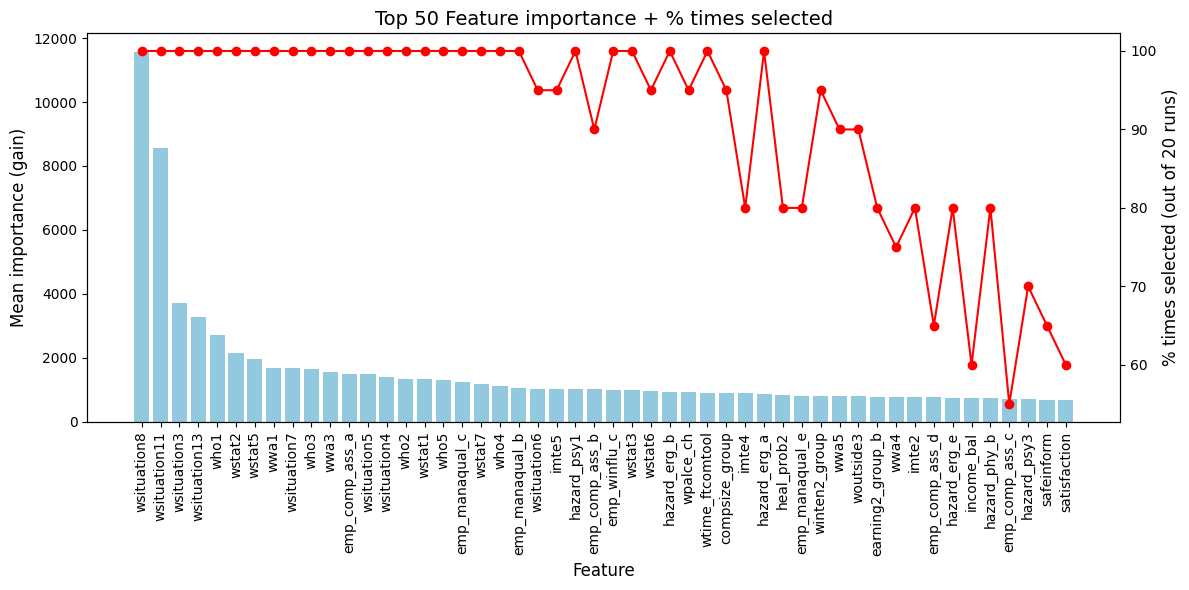

In [66]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# 1. 반복 학습 & 변수 선택 기록
# -------------------------
n_iter = 20          # 반복 횟수 (논문에서는 20번)
top_n = 50           # 매 반복에서 상위 N개 변수 선택
selected_counts = Counter()
importance_values = []

for i in range(n_iter):
    # 데이터 샘플링 (train/val split, 부트스트랩)
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=i
    )
    
    # 모델 학습
    model = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        class_weight="balanced",
        random_state=i,
        n_estimators=200
    )
    model.fit(X_tr, y_tr)
    
    # 변수 중요도 (gain 기준)
    importances = model.booster_.feature_importance(importance_type="gain")
    features = model.booster_.feature_name()
    
    # 상위 N개 선택
    top_idx = np.argsort(importances)[::-1][:top_n]
    for idx in top_idx:
        selected_counts[features[idx]] += 1
    
    # 평균 importance 계산용 저장
    importance_values.append(importances)

# -------------------------
# 2. 평균 importance와 % times selected 계산
# -------------------------
mean_importance = np.mean(importance_values, axis=0)
df_importance = pd.DataFrame({
    "feature": features,
    "importance_gain": mean_importance,
    "%_times_selected": [selected_counts[f]/n_iter*100 for f in features]
})

# 상위 20개만 정렬
df_top = df_importance.sort_values(by="importance_gain", ascending=False).head(top_n)

# -------------------------
# 3. Figure 1 스타일 시각화
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# 막대그래프 (평균 gain importance)
sns.barplot(
    data=df_top,
    x="feature", y="importance_gain",
    color="skyblue", ax=ax1
)
ax1.set_ylabel("Mean importance (gain)", fontsize=12)
ax1.set_xlabel("Feature", fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# 2축 (% times selected)
ax2 = ax1.twinx()
ax2.plot(df_top["feature"], df_top["%_times_selected"], color="red", marker="o")
ax2.set_ylabel("% times selected (out of 20 runs)", fontsize=12)

plt.title(f"Top {top_n} Feature importance + % times selected", fontsize=14)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 636
[LightGBM] [Info] Number of data points in the train set: 519, number of used features: 132
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

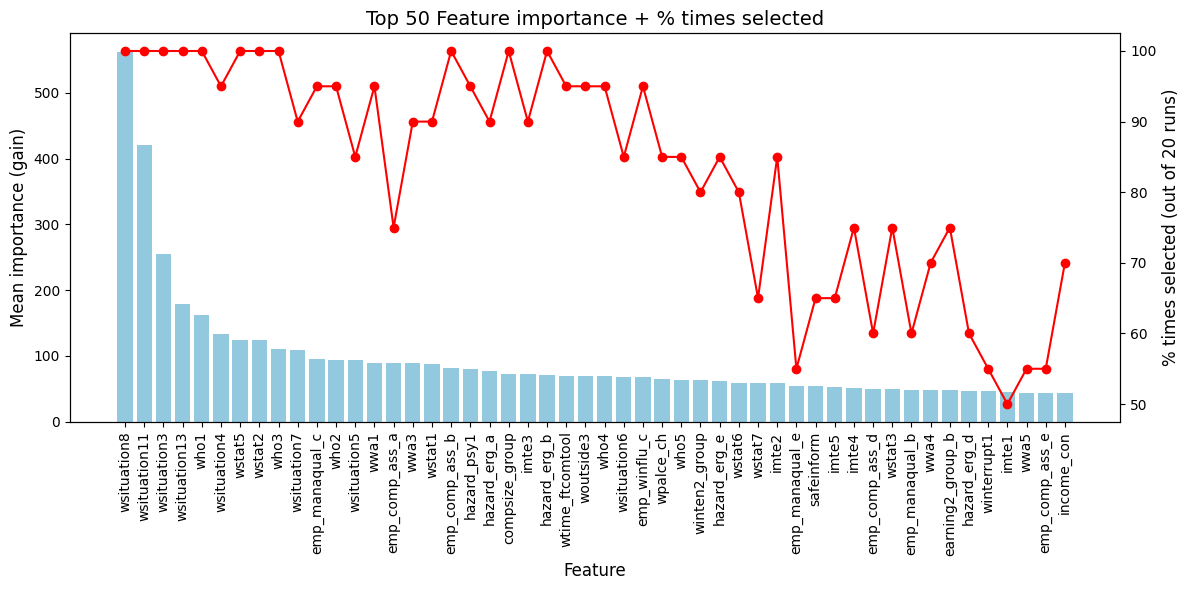

In [67]:
from imblearn.under_sampling import RandomUnderSampler

# -------------------------
# 1. 반복 학습 & 변수 선택 기록
# -------------------------
n_iter = 20          # 반복 횟수 (논문에서는 20번)
top_n = 50           # 매 반복에서 상위 N개 변수 선택
selected_counts = Counter()
importance_values = []

for i in range(n_iter):
    # 데이터 샘플링 (train/val split, 부트스트랩)
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_X, train_Y, test_size=0.2, stratify=train_Y, random_state=i
    )
    
    # 다운샘플링
    rus = RandomUnderSampler(random_state=i)
    X_tr, y_tr = rus.fit_resample(X_tr, y_tr)
    
    # 모델 학습
    model = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        class_weight="balanced",
        random_state=i,
        n_estimators=200
    )
    model.fit(X_tr, y_tr)
    
    # 변수 중요도 (gain 기준)
    importances = model.booster_.feature_importance(importance_type="gain")
    features = model.booster_.feature_name()
    
    # 상위 N개 선택
    top_idx = np.argsort(importances)[::-1][:top_n]
    for idx in top_idx:
        selected_counts[features[idx]] += 1
    
    # 평균 importance 계산용 저장
    importance_values.append(importances)

# -------------------------
# 2. 평균 importance와 % times selected 계산
# -------------------------
mean_importance = np.mean(importance_values, axis=0)
df_importance = pd.DataFrame({
    "feature": features,
    "importance_gain": mean_importance,
    "%_times_selected": [selected_counts[f]/n_iter*100 for f in features]
})

# 상위 20개만 정렬
df_top = df_importance.sort_values(by="importance_gain", ascending=False).head(top_n)

# -------------------------
# 3. Figure 1 스타일 시각화
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# 막대그래프 (평균 gain importance)
sns.barplot(
    data=df_top,
    x="feature", y="importance_gain",
    color="skyblue", ax=ax1
)
ax1.set_ylabel("Mean importance (gain)", fontsize=12)
ax1.set_xlabel("Feature", fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# 2축 (% times selected)
ax2 = ax1.twinx()
ax2.plot(df_top["feature"], df_top["%_times_selected"], color="red", marker="o")
ax2.set_ylabel("% times selected (out of 20 runs)", fontsize=12)

plt.title(f"Top {top_n} Feature importance + % times selected", fontsize=14)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27674
[LightGBM] [Info] Number of data points in the train set: 4658, number of used features: 146
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

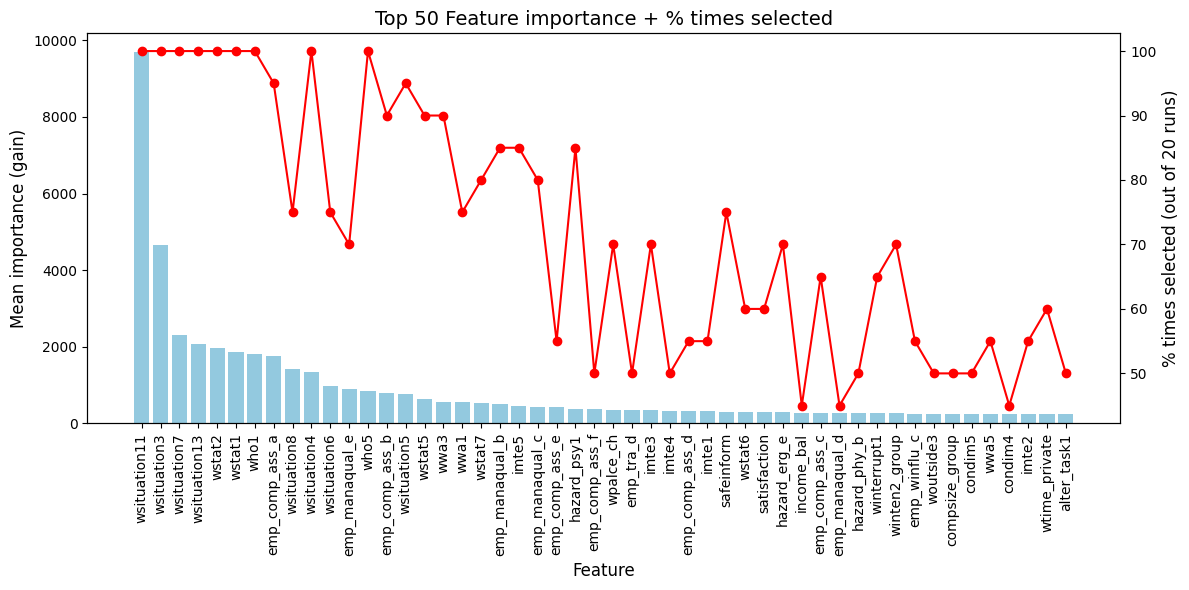

In [67]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

# -------------------------
# 1. 반복 학습 & 변수 선택 기록
# -------------------------
n_iter = 20          # 반복 횟수 (논문에서는 20번)
top_n = 50           # 매 반복에서 상위 N개 변수 선택
selected_counts = Counter()
importance_values = []

for i in range(n_iter):
    # 데이터 샘플링 (train/val split, 부트스트랩)
    X_tr, X_val, y_tr, y_val = train_test_split(
        train_X, train_Y, test_size=0.8, stratify=train_Y, random_state=i
    )
    
    # SMOTE-ENN
    smote = SMOTE(random_state=i, k_neighbors=3)
    smote_enn = SMOTEENN(random_state=i, smote=smote)
    X_tr, y_tr = smote_enn.fit_resample(X_tr, y_tr)
    
    # 모델 학습
    model = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        class_weight="balanced",
        random_state=i,
        n_estimators=200
    )
    model.fit(X_tr, y_tr)
    
    # 변수 중요도 (gain 기준)
    importances = model.booster_.feature_importance(importance_type="gain")
    features = model.booster_.feature_name()
    
    # 상위 N개 선택
    top_idx = np.argsort(importances)[::-1][:top_n]
    for idx in top_idx:
        selected_counts[features[idx]] += 1
    
    # 평균 importance 계산용 저장
    importance_values.append(importances)

# -------------------------
# 2. 평균 importance와 % times selected 계산
# -------------------------
mean_importance = np.mean(importance_values, axis=0)
df_importance = pd.DataFrame({
    "feature": features,
    "importance_gain": mean_importance,
    "%_times_selected": [selected_counts[f]/n_iter*100 for f in features]
})

# 상위 20개만 정렬
df_top = df_importance.sort_values(by="importance_gain", ascending=False).head(top_n)

# -------------------------
# 3. Figure 1 스타일 시각화
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# 막대그래프 (평균 gain importance)
sns.barplot(
    data=df_top,
    x="feature", y="importance_gain",
    color="skyblue", ax=ax1
)
ax1.set_ylabel("Mean importance (gain)", fontsize=12)
ax1.set_xlabel("Feature", fontsize=12)
ax1.tick_params(axis='x', rotation=90)

# 2축 (% times selected)
ax2 = ax1.twinx()
ax2.plot(df_top["feature"], df_top["%_times_selected"], color="red", marker="o")
ax2.set_ylabel("% times selected (out of 20 runs)", fontsize=12)

plt.title(f"Top {top_n} Feature importance + % times selected", fontsize=14)
plt.tight_layout()
plt.show()

### RFECV 변수 선택 model

In [68]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# 모델 정의
final_model = LGBMClassifier(
    objective="multiclass",
    num_class=3,
    class_weight="balanced",
    random_state=42,
    n_estimators=best_iter  # 최적 반복 수 적용
)

# 교차검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RFECV 실행
rfecv = RFECV(
    estimator=final_model,
    step=1,                  # 한 번에 제거할 변수 개수
    cv=cv,                   # 교차검증 방식
    scoring="roc_auc_ovr",   # 다중분류 AUC (One-vs-Rest)
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

print("최적 변수 개수:", rfecv.n_features_)
print("선택된 변수:", train_X.columns[rfecv.support_])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 6806, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 6806, number of used features: 148
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start tr

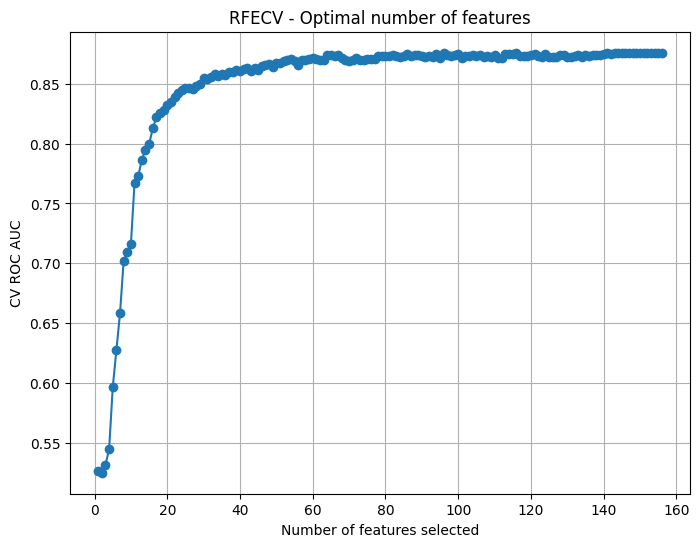

In [69]:
# 성능 그래프 (최적 변수 개수 vs CV score)
plt.figure(figsize=(8,6))

# grid_scores_ 대신 cv_results_ 사용
mean_test_scores = rfecv.cv_results_['mean_test_score']

plt.plot(range(1, len(mean_test_scores) + 1), mean_test_scores, marker='o')
plt.xlabel("Number of features selected")
plt.ylabel("CV ROC AUC")
plt.title("RFECV - Optimal number of features")
plt.grid(True)
plt.show()

In [ ]:
# # RFECV에서 선택된 변수
# optimal_features = train_X.columns[rfecv.support_]

# # X_train에서 선택된 변수만 저장
# X_train_selected = train_X[optimal_features]